## **Import packages for analysis**

In [1]:
import sys
sys.path.insert(0, '/home/tchari/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

In [3]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import scipy.stats

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

import os

# import hdbscan
import sklearn

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## **Import data and metadata**

In [5]:
meta_path = "/home/tchari/metadata/"
meta = pd.read_csv(meta_path+'norman_GSE133344_filtered_cell_identities.csv')

#'guide_identity'

In [6]:
meta.head()

,cell_barcode,guide_identity,read_count,UMI_count,coverage,gemgroup,good_coverage,number_of_cells
0,TTGAACGAGACTCGGA-2,ARID1A_NegCtrl0__ARID1A_NegCtrl0,28684,1809,15.856274,2,True,1
1,CGTTGGGGTGTTTGTG-7,BCORL1_NegCtrl0__BCORL1_NegCtrl0,18367,896,20.498884,7,True,1
2,GAACCTAAGTGTTAGA-6,FOSB_NegCtrl0__FOSB_NegCtrl0,16296,664,24.542169,6,True,1
3,CCTTCCCTCCGTCATC-4,SET_KLF1__SET_KLF1,16262,850,19.131765,4,True,1
4,TCAATCTGTCTTTCAT-2,OSR2_NegCtrl0__OSR2_NegCtrl0,16057,1067,15.048735,2,True,2


In [7]:
ids = list(meta['guide_identity'].value_counts().index)
counts = list(meta['guide_identity'].value_counts())

saveCounts = pd.DataFrame()
saveCounts['guide_identity'] = ids
saveCounts['cells'] = counts

Select for all guides/conditions with > 50 cells

In [8]:
filt_ids = list(saveCounts['guide_identity'][saveCounts['cells'] >  50])
len(filt_ids)

290

Set up output files + paths to looms for the different guide conditions for *Monod*

In [9]:
dataset_meta = ['allcrispr']
print('dataset_meta: ', dataset_meta)
print()

subcluster_names = [[i] for i in filt_ids]

sub_names_only = ['_'.join(n) for n in subcluster_names]

cluster_names = []
dataset_names = ['norman_'+dataset_meta[0]+'_'+y  for y in sub_names_only]   #To save
#print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = [dataset_meta[0] for y in sub_names_only]
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/norman_crispr/loom/'+x+'.loom' for x in raw_data_locations] 
#print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

dataset_meta:  ['allcrispr']

len(dataset_names):  290



## **Cell Preprocessing**

Filter for cell barcodes with enough UMIs

Dataset allcrispr. 
	116844 barcodes in loom, 94649 pass filter. 111445 in annotations; of these, 111445 in loom and 94514 in filtered loom.
	['NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0']: 3532 cells in annotations. 3532 in loom. 3255 pass filter.
	['NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0']: 2948 cells in annotations. 2948 in loom. 2679 pass filter.
	['NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0']: 2839 cells in annotations. 2839 in loom. 2622 pass filter.
	['NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0']: 2536 cells in annotations. 2536 in loom. 2362 pass filter.
	['CEBPE_RUNX1T1__CEBPE_RUNX1T1']: 1219 cells in annotations. 1219 in loom. 1018 pass filter.
	['KLF1_NegCtrl0__KLF1_NegCtrl0']: 1197 cells in annotations. 1197 in loom. 1109 pass filter.
	['TBX3_TBX2__TBX3_TBX2']: 1167 cells in annotations. 1167 in loom. 1028 pass filter.
	['SLC4A1_NegCtrl0__SLC4A1_NegCtrl0']: 1000 cells in annotations. 1000 in loom. 882 pass filter.
	['ETS2_CNN1__ETS2_CNN1']: 905 cells in annotations. 905 in loom. 798 pass f

	['HOXB9_NegCtrl0__HOXB9_NegCtrl0']: 410 cells in annotations. 410 in loom. 334 pass filter.
	['NegCtrl0_SPI1__NegCtrl0_SPI1']: 403 cells in annotations. 403 in loom. 301 pass filter.
	['UBASH3B_CNN1__UBASH3B_CNN1']: 402 cells in annotations. 402 in loom. 292 pass filter.
	['NegCtrl0_TGFBR2__NegCtrl0_TGFBR2']: 401 cells in annotations. 401 in loom. 362 pass filter.
	['CNN1_MAPK1__CNN1_MAPK1']: 398 cells in annotations. 398 in loom. 329 pass filter.
	['KLF1_BAK1__KLF1_BAK1']: 395 cells in annotations. 395 in loom. 360 pass filter.
	['DLX2_NegCtrl0__DLX2_NegCtrl0']: 387 cells in annotations. 387 in loom. 333 pass filter.
	['FOSB_OSR2__FOSB_OSR2']: 382 cells in annotations. 382 in loom. 318 pass filter.
	['DUSP9_IGDCC3__DUSP9_IGDCC3']: 382 cells in annotations. 382 in loom. 286 pass filter.
	['ATL1_NegCtrl0__ATL1_NegCtrl0']: 379 cells in annotations. 379 in loom. 288 pass filter.
	['LHX1_NegCtrl0__LHX1_NegCtrl0']: 375 cells in annotations. 375 in loom. 306 pass filter.
	['NegCtrl0_FOXA1__

	['DUSP9_MAPK1__DUSP9_MAPK1']: 290 cells in annotations. 290 in loom. 260 pass filter.
	['CEBPB_NegCtrl0__CEBPB_NegCtrl0']: 286 cells in annotations. 286 in loom. 211 pass filter.
	['CNN1_NegCtrl0__CNN1_NegCtrl0']: 285 cells in annotations. 285 in loom. 251 pass filter.
	['NegCtrl0_FOXL2__NegCtrl0_FOXL2']: 284 cells in annotations. 284 in loom. 227 pass filter.
	['FEV_ISL2__FEV_ISL2']: 284 cells in annotations. 284 in loom. 153 pass filter.
	['PTPN12_SNAI1__PTPN12_SNAI1']: 283 cells in annotations. 283 in loom. 244 pass filter.
	['SAMD1_NegCtrl0__SAMD1_NegCtrl0']: 281 cells in annotations. 281 in loom. 210 pass filter.
	['KIAA1804_NegCtrl0__KIAA1804_NegCtrl0']: 278 cells in annotations. 278 in loom. 250 pass filter.
	['FEV_MAP7D1__FEV_MAP7D1']: 277 cells in annotations. 277 in loom. 193 pass filter.
	['AHR_FEV__AHR_FEV']: 276 cells in annotations. 276 in loom. 140 pass filter.
	['HOXA13_NegCtrl0__HOXA13_NegCtrl0']: 274 cells in annotations. 274 in loom. 173 pass filter.
	['FOXA1_FOXF1_

	['PLK4_NegCtrl0__PLK4_NegCtrl0']: 113 cells in annotations. 113 in loom. 92 pass filter.
	['CDKN1C_CDKN1B__CDKN1C_CDKN1B']: 107 cells in annotations. 107 in loom. 97 pass filter.
	['PRDM1_CBFA2T3__PRDM1_CBFA2T3']: 106 cells in annotations. 106 in loom. 40 pass filter.
	['ZBTB10_SNAI1__ZBTB10_SNAI1']: 100 cells in annotations. 100 in loom. 42 pass filter.
	['KIF18B_KIF2C__KIF18B_KIF2C']: 96 cells in annotations. 96 in loom. 71 pass filter.
	['FOXL2_HOXB9__FOXL2_HOXB9']: 96 cells in annotations. 96 in loom. 52 pass filter.
	['HOXC13_NegCtrl0__HOXC13_NegCtrl0_2']: 91 cells in annotations. 91 in loom. 54 pass filter.
	['ZBTB10_DLX2__ZBTB10_DLX2']: 89 cells in annotations. 89 in loom. 42 pass filter.
	['ZBTB10_NegCtrl0__ZBTB10_NegCtrl0_1']: 86 cells in annotations. 86 in loom. 57 pass filter.
	['ZC3HAV1_CEBPA__ZC3HAV1_CEBPA']: 86 cells in annotations. 86 in loom. 50 pass filter.
	['PLK4_STIL__PLK4_STIL']: 81 cells in annotations. 81 in loom. 68 pass filter.
	['ZBTB10_NegCtrl0__ZBTB10_NegCt

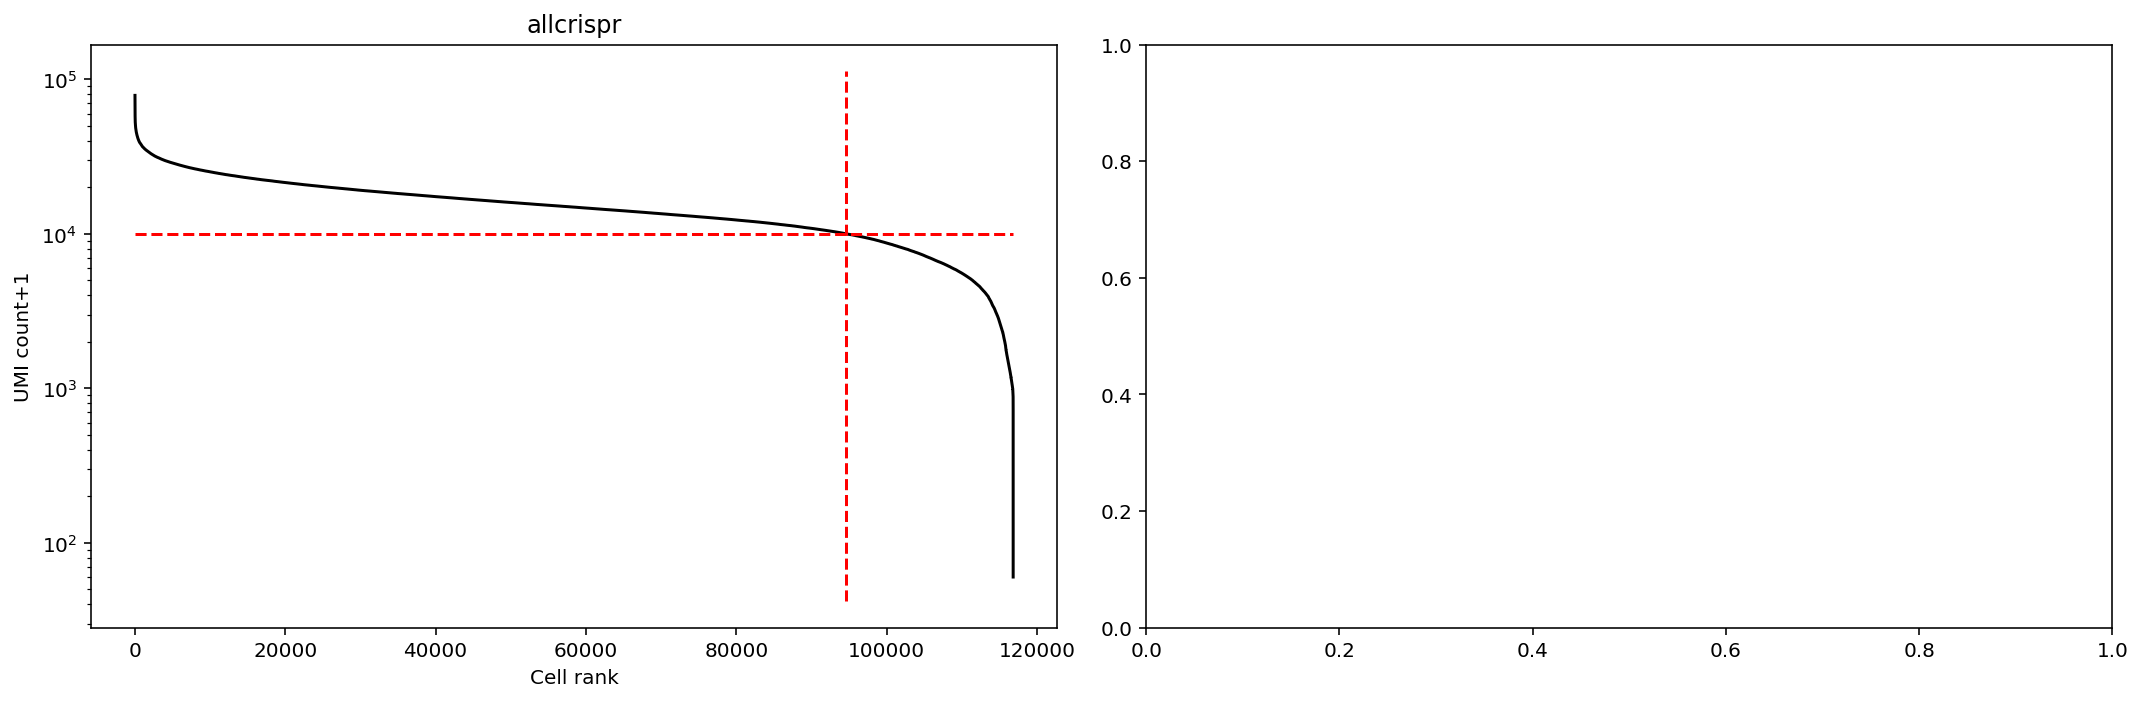

In [10]:
cf = []
thr_lb = [1e4]*len(dataset_meta)*2

fig1,ax1 = plt.subplots(1,len(dataset_meta)*2,figsize=(15,5))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(subcluster_names)*k]
    dataset_name = raw_data_locations[len(subcluster_names)*k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = len(meta['cell_barcode'])
        annot_bcs_in_loom = meta['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        #if k==0:
        for subcluster in subcluster_names:
            annot_bcs = meta[(meta['guide_identity'].isin(subcluster))]['cell_barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')



    ax1[k].set_title(dataset_name)
    
!mkdir ./figs    
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_all_norman.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

In [11]:
#Conditions with too few cells after filtering
ok = []
okinds = []
for i in range(len(subcluster_names)):
    x = cf[i]
    if x.sum() > 50:
        ok += [subcluster_names[i]]
        okinds += [i]
print(len(ok))

277


In [12]:
#re-filter
dataset_meta = ['allcrispr']
print('dataset_meta: ', dataset_meta)
print()

subcluster_names = [i for i in ok]

sub_names_only = ['_'.join(n) for n in subcluster_names]

cluster_names = []
dataset_names = ['norman_'+dataset_meta[0]+'_'+y  for y in sub_names_only]   #To save
print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = [dataset_meta[0] for y in sub_names_only]
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/norman_crispr/loom/'+x+'.loom' for x in raw_data_locations] 
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

cf = np.array(cf)[okinds]

dataset_meta:  ['allcrispr']

dataset_names:  ['norman_allcrispr_NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0', 'norman_allcrispr_NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0', 'norman_allcrispr_NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0', 'norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0', 'norman_allcrispr_CEBPE_RUNX1T1__CEBPE_RUNX1T1', 'norman_allcrispr_KLF1_NegCtrl0__KLF1_NegCtrl0', 'norman_allcrispr_TBX3_TBX2__TBX3_TBX2', 'norman_allcrispr_SLC4A1_NegCtrl0__SLC4A1_NegCtrl0', 'norman_allcrispr_ETS2_CNN1__ETS2_CNN1', 'norman_allcrispr_UBASH3B_OSR2__UBASH3B_OSR2', 'norman_allcrispr_DUSP9_ETS2__DUSP9_ETS2', 'norman_allcrispr_NegCtrl0_BAK1__NegCtrl0_BAK1', 'norman_allcrispr_NegCtrl0_KLF1__NegCtrl0_KLF1', 'norman_allcrispr_NegCtrl0_ETS2__NegCtrl0_ETS2', 'norman_allcrispr_DUSP9_NegCtrl0__DUSP9_NegCtrl0', 'norman_allcrispr_BAK1_NegCtrl0__BAK1_NegCtrl0', 'norman_allcrispr_SET_KLF1__SET_KLF1', 'norman_allcrispr_NegCtrl0_CEBPE__NegCtrl0_CEBPE', 'norman_allcrispr_CBL_NegCtrl0__CBL_NegCtrl0', 'norman_allcri

In [13]:
#final list of selected barcodes in each condition
cf = list(cf)

## **Gene Filtering**

Select moderately expressed genes across all the conditions

In [14]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [25]:
!mkdir ./fits

mkdir: cannot create directory ‘./fits’: File exists


Run *Monod* preprocssing to set up output files/folders

In [ ]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='norman_crispr_all',batch_id=1,\
                                             n_genes=3000,exp_filter_threshold=None,cf=cf)

In [15]:
dir_string = './fits/gg_230831_025_norman_crispr_all_1' #gg_230215_025_norman_crispr_all_1
dataset_strings = [dir_string+'/'+i for i in dataset_names]

In [16]:
print(dataset_strings[0])
print(len(dataset_strings))

./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0
277


In [ ]:
# For RBPs select genes with changes in relevant parameter:

# splicing factors:
# ['SNRP70','HRNPLL','MBNL2','MBNL1','SF3B1','U2AF','SRSF2']

# terminal erythropoiesis
# other: ['RBM38','HNRNPA1']
# target: ['EBP41','EBP41']

# AUF1 paper
# degradation reps:['AUF1',]
# targets:['TNF','IL8','IL10','PLEK2','BCL2']

# Regulation 2001
# ['MYC'] degraded in K562 cells --> megakaryoblasts


# RBPS in erythropoiesis https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6066521/ + original paper:
# diff markers: ['GATA1','KLF1','SLC25A37','CD235a','GYPA',
# 'IGBP1','eIF4E','ATF4','PPR15a','GADD34']

# deg: ['PABPC1','PABPC4','CPEB4','ZFP36','ZFP36L1','ZFP36L2','ELAV1','CSDE1']
# targets: ['HBA1','KIT','eIF3','STAT5B','PABPC1']


# Deg genes elife paper:
# elife-49708-supp1-v2.xlsx, DDX6 knockout results
# deg: ['DDX6','DCP1','DCP2','PAT1B','XRN1','SMG6','YTHDF2','ATXN2']
# #possible list of target cited https://elifesciences.org/articles/49708#content 


# Add genes from perturb-sci-kinetics:

# trans_init_syn_chrom = ['GTF2E1', 'TAF2', 'MED21','MNAT1','POLR2B','POLR2K','SMC3',
# 'RAD21','CTCF','ARID1A' ]
# splic_proc = ['NCBP1','LSM2', 'LSM4', 'PRPF38B', 'HNRNPK','CPSF2', 'CPSF6', 'NUDT21', 'CSTF3']
# oxphos = ['GAPDH', 'NDUFS2', 'ACO2']
# trans_silence = ['GAPDH, NDUFS2, 191 ACO2']
# deg_process = ['UPF1', 'UPF2', 'SMG5', 'SMG7','EXOSC2', 'EXOSC5', 'EXOSC6',
# 'CSTF3', 'CPSF2', 'CPSF6', 'NUDT21', 'XRN2','RNMT', 'NCBP1' ]
# --------

#'ARRDC3' downregulates 'ITGB4'
#SNAI1 repressed CDH1 (Cadherin),NANOG, NR5A2, KIT -> https://stemcellsjournals.onlinelibrary.wiley.com/doi/full/10.1002/stem.1898
# Apoptosis--> global mRNA decay ,
#CBL targets -->EGFR, FLT3, KIT, MPL https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4775400/
#ubash3b (also + CBL) targets --> 
#ETS/FEV trans factors
#KMT2A methylation 
#MIDN degrades FOSB, EGR1, NR4A1, IRF4, NEUROD1, PAX8, GATA1 https://www.science.org/doi/10.1126/science.adh5021
#RUNX1T1 --> PTK2B, RBFOX2 alt splicing https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7822815/

Add all the genes that were single targets, to be fit

In [17]:
first = [i.split('_')[0] for i in ids]
secnd = [i.split('_')[1] for i in ids]

all_targets = np.unique(first+secnd)

In [18]:
all_targets

array(['AHR', 'ARID1A', 'ARRDC3', 'ATL1', 'BAK1', 'BCL2L11', 'BCORL1',
       'BPGM', 'C19orf26', 'C3orf72', 'CBFA2T3', 'CBL', 'CDKN1A',
       'CDKN1B', 'CDKN1C', 'CEBPA', 'CEBPB', 'CEBPE', 'CELF2', 'CITED1',
       'CKS1B', 'CLDN6', 'CNN1', 'CNNM4', 'COL1A1', 'COL2A1', 'CSRNP1',
       'DLX2', 'DUSP9', 'EGR1', 'ELMSAN1', 'ETS2', 'FEV', 'FOSB', 'FOXA1',
       'FOXA3', 'FOXF1', 'FOXL2', 'FOXO4', 'GLB1L2', 'HES7', 'HK2',
       'HNF4A', 'HOXA13', 'HOXB9', 'HOXC13', 'IER5L', 'IGDCC3', 'IKZF3',
       'IRF1', 'ISL2', 'JUN', 'KIAA1804', 'KIF18B', 'KIF2C', 'KLF1',
       'KMT2A', 'LHX1', 'LYL1', 'MAML2', 'MAP2K3', 'MAP2K6', 'MAP4K3',
       'MAP4K5', 'MAP7D1', 'MAPK1', 'MEIS1', 'MIDN', 'NCL', 'NIT1',
       'NegCtrl0', 'NegCtrl1', 'NegCtrl10', 'NegCtrl11', 'OSR2', 'PLK4',
       'POU3F2', 'PRDM1', 'PRTG', 'PTPN1', 'PTPN12', 'PTPN13', 'PTPN9',
       'RHOXF2', 'RREB1', 'RUNX1T1', 'S1PR2', 'SAMD1', 'SET', 'SGK1',
       'SLC38A2', 'SLC4A1', 'SLC6A9', 'SNAI1', 'SPI1', 'STIL', 'TBX2',
       '

In [19]:
new_genes = ['ITGB4','CDH1','NANOG', 'NR5A2', 'KIT', 'EGFR', 'FLT3', 'MPL',
            'FOSB', 'EGR1', 'NR4A1', 'IRF4', 'NEUROD1', 'PAX8', 'GATA1','PTK2B', 'RBFOX2']

In [20]:
ds = lp.connect(loom_filepaths[0])
g_names = ds.ra['gene_name']
ds.close()


In [22]:
#Filter out genes not in original data
markers = [i for i in new_genes if i in g_names]
markers = np.unique(markers+list(all_targets))

#Filter for genes in transcriptome reference + without duplicate references
annots=pd.read_csv('/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3',delim_whitespace=True,header=None)

filt_markers = [m for m in markers if m in list(annots[0])]
len(filt_markers)

116

In [38]:
#Add genes to genes.csv file created by Monod (for inference)
to_change = pd.read_csv('./fits/gg_230831_025_norman_crispr_all_1/genes.csv',header=None)
first_sel = list(to_change.iloc[0])

In [39]:
uniq = [i for i in filt_markers if i not in first_sel]
first_sel = first_sel+uniq

In [49]:
#Save to original genes.csv
new_pd = pd.DataFrame(columns=range(len(first_sel)))
new_pd.loc[0] = first_sel
new_pd.to_csv('./fits/gg_230831_025_norman_crispr_all_1/genes.csv',header=None,index=None)

In [54]:
# # Test reading file in to see if it worked
# test = pd.read_csv('./fits/gg_230831_025_norman_crispr_all_1/genes.csv',header=None)

## **Run *Monod* Parameter Inference**

In [21]:
#Define bounds, from 20220930_normanfit_monod.ipynb
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-7.157894736842105, -1.525] #-7.5, -2
samp_ub = [-7.157894736842105, -1.525] #-5.5, 0
# gridsize = [5,6]
gridsize = [1,1]  #No grid because we already know this value from the norman_perturb_prediction notebook


In [ ]:
result_strings = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':10,'init_pattern':'moments','num_restarts':5})
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)

In [22]:
result_strings = [i+'/Bursty_Poisson_1x1/grid_scan_results.res' for i in dataset_strings]
print(result_strings[0])

./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results.res


## **QC and Analysis of Results**

In [23]:
# a e s t h e t i c s
from matplotlib.colors import ListedColormap

#all
col_gold = [203/255,197/255,149/255]
col_gray = [116/255,112/255,113/255]
col_red = [212/255,107/255,75/255]
col_b = ['#1B9AAA']
col_beta = ['#9fcbee']
col_gamma =['#3C50B1']
col_expr = ['#9299A0']

### SI figures
ms = 0.7
lw = ms
ms_fail = 1
alf = 0.3
alf_fail = 0.5
sifig_aesth = (ms,lw,ms_fail,alf,alf_fail)

### Body figures
ms = 2
lw = ms
ms_fail = 2
alf = 0.3
alf_fail = 0.8
msfig_aesth = (ms,lw,ms_fail,alf,alf_fail)

markerstyle = None

c_highlight = col_red
c1 = [173/255,214/255,200/255]
c2 = [59/255,131/255,130/255]
ncol=20
cmap = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(3)]).T)

In [24]:
n_datasets

277

In [25]:
#Read back in data
sr_arr = [monod.analysis.load_search_results(r) for r in result_strings] 

INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_CEBPE_RUNX1T1__CEBPE_RUNX1T1/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_KLF1_NegCtrl0__KLF1_N

INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_FOXA3_NegCtrl0__FOXA3_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_SGK1_NegCtrl0__SGK1_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_AHR_KLF1__AHR_KLF1/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_CNN1__NegCtrl0_CNN1/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_FOXA1_NegCtrl0__FOXA1_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_CSRNP1_NegCtrl0__CSRNP1_NegCtrl0/Bursty_Poisson_1x1/grid_scan_r

INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_LHX1_NegCtrl0__LHX1_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_FOXA1__NegCtrl0_FOXA1/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_TBX3_NegCtrl0__TBX3_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_UBASH3A__NegCtrl0_UBASH3A/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_IGDCC3_MAPK1__IGDCC3_MAPK1/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_FOXL2_NegCtrl0__FOXL2_NegCtrl0/Bursty_Poisson_1x1/g

INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_ETS2_MAP7D1__ETS2_MAP7D1/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_TBX3__NegCtrl0_TBX3/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_EGR1_NegCtrl0__EGR1_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_FOXF1__NegCtrl0_FOXF1/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_RHOXF2_SET__RHOXF2_SET/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_MAPK1_NegCtrl0__MAPK1_NegCtrl0/Bursty_Poisson_1x1/grid_scan_resul

INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_ZBTB10_PTPN12__ZBTB10_PTPN12/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_IGDCC3__NegCtrl0_IGDCC3/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_C3orf72_NegCtrl0__C3orf72_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_RHOXF2_ZBTB25__RHOXF2_ZBTB25/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_KLF1_MAP2K6__KLF1_MAP2K6/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_MAP2K3_IKZF3__MAP2K3_IKZF3/Bursty_Poisson_1x1/grid_

INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_CDKN1B__NegCtrl0_CDKN1B/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_CDKN1A_NegCtrl0__CDKN1A_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_IER5L_NegCtrl0__IER5L_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_DUSP9_SNAI1__DUSP9_SNAI1/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_ZBTB10_ELMSAN1__ZBTB10_ELMSAN1/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_CEBPE_CEBPA__CEBPE_CEBPA/Bursty_Poisson_1x1/grid_

In [68]:
#--- Reject genes from goodness of fit testing and  calculate std error -----
for i in range(len(sr_arr)):
    sr = sr_arr[i]
    sr.set_sampling_optimum(sr.sp.sampl_vals.index((-7.157894736842105, -1.525)))  
    
    sd = monod.analysis.load_search_data(dataset_strings[i]+'/raw.sd')
    _=sr.chisquare_testing(sd,reject_at_bounds=True) #EPS=1e-20
    sr.compute_sigma(sd,num_cores=30)
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()

INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 64 genes out of 3084. Runtime: 20.1 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 124 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 144 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 260 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 264 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 542 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 677 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1043 gives negative 

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 71 genes out of 3084. Runtime: 19.7 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 36 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 264 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 601 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 643 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 775 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1096 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1137 gives negative s

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Standard error of the MLE computation complete. Runtime: 134.8 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 70 genes out of 3084. Runtime: 19.7 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 321 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 343 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 629 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 915 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1078 gives negative stdev; replaced with

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 3028 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3033 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3037 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3039 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3041 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3043 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3044 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3047 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3072 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3073 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_CEBPE_RUNX1T1__CEBPE_RUNX1T1/raw.sd.
INFO:root:Chi-square computation complete. Rejected 124 genes out of 3084. Runtime: 19.5 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 41 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 43 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 164 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 278 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 483 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 539 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 578 gives negative stdev; repla

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_KLF1_NegCtrl0__KLF1_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 118 genes out of 3084. Runtime: 21.2 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 43 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 64 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 74 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 78 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 241 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 348 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 473 gives negative stdev; replace

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_TBX3_TBX2__TBX3_TBX2/raw.sd.
INFO:root:Chi-square computation complete. Rejected 118 genes out of 3084. Runtime: 20.0 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 34 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 323 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 391 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 467 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 576 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 601 ran into singularity; replaced wi

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2946 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3010 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3013 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3026 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3038 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3039 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3045 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3046 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3054 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2823 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2948 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3033 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3045 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3068 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3080 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 118.6 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_ETS2_CNN1__ETS2_CNN1/raw.sd.
INFO:root:Chi-square computation complete. Rejected 128 genes out of 3084. Runtime: 18.8 seconds.
INFO:root:C

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Standard error of the MLE computation complete. Runtime: 95.1 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_UBASH3B_OSR2__UBASH3B_OSR2/raw.sd.
INFO:root:Chi-square computation complete. Rejected 139 genes out of 3084. Runtime: 22.5 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 127 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 202 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 223 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 260 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 277 gives negative stdev; replaced with mean. (Searc

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2632 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2869 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2963 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3030 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3045 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3072 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 101.1 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_DUSP9_ETS2__DUSP9_ETS2/raw.sd.
INFO:ro

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2385 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2424 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2506 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2547 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2627 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2632 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2701 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2728 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2794 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2830 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2476 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2506 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2568 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2591 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2609 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2670 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2729 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2778 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2826 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_ETS2__NegCtrl0_ETS2/raw.sd.
INFO:root:Chi-square computation complete. Rejected 169 genes out of 3084. Runtime: 21.5 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 48 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 67 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 144 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 159 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 190 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 277 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 285 gives negative stdev; repla

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_DUSP9_NegCtrl0__DUSP9_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 187 genes out of 3084. Runtime: 9.7 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 10 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 145 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 185 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 212 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 263 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 299 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 535 gives negative stdev; rep

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 3020 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3022 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3024 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3026 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3033 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3035 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3036 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3045 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3076 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3080 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2541 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2543 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2732 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2771 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2805 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2848 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2929 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2963 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3002 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_CEBPE__NegCtrl0_CEBPE/raw.sd.
INFO:root:Chi-square computation complete. Rejected 178 genes out of 3084. Runtime: 17.6 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 3 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 107 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 242 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 467 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 471 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 532 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 576 ran into singularity; rep

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2245 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2408 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2466 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2497 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2500 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2535 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2560 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2565 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2591 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2609 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 2175 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2455 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2506 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2569 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2595 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2632 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2664 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2671 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2743 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2764 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2823 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2863 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2589 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2631 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2640 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2701 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2708 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2847 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3010 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3012 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3026 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3045 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_ZNF318_NegCtrl0__ZNF318_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 142 genes out of 3084. Runtime: 10.7 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 123 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 156 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 202 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 212 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 264 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 305 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 345 gives negative stdev;

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2756 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2785 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2839 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2872 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3005 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3047 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3068 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 101.8 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_LHX1_ELMSAN1__LHX1_ELMSAN1/raw.sd.
INF

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_FOSB_NegCtrl0__FOSB_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 163 genes out of 3084. Runtime: 10.6 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 31 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 187 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 257 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 260 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 287 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 391 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 576 ran into singularity; repl

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Standard error of the MLE computation complete. Runtime: 99.8 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_MAML2_NegCtrl0__MAML2_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 174 genes out of 3084. Runtime: 19.6 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 5 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 61 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 89 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 94 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 267 gives negative stdev; replaced with mean. (Search

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2565 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2605 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2709 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2778 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2872 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2911 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2929 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2931 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3013 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3018 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2272 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2303 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2348 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2448 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2450 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2459 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2506 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2511 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2560 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2637 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

INFO:root:Gene 2481 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2523 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2542 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2552 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2557 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2611 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2651 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2697 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2718 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_UBASH3B__NegCtrl0_UBASH3B/raw.sd.
INFO:root:Chi-square computation complete. Rejected 162 genes out of 3084. Runtime: 18.2 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 7 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 94 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 240 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 246 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 299 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 369 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 437 gives negative stdev; 

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_UBASH3B_NegCtrl0__UBASH3B_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 171 genes out of 3084. Runtime: 18.2 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 98 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 208 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 250 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 278 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 482 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 498 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 576 ran into singularity

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2570 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2609 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2830 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2841 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2901 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3008 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3012 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3013 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3022 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3026 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2212 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2242 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2257 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2382 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2399 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2500 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2570 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2591 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2591 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2595 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2609 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2749 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2756 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2858 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2963 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2968 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2977 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3008 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 3053 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3071 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3076 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 96.8 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_MAP2K3_MAP2K6__MAP2K3_MAP2K6/raw.sd.
INFO:root:Chi-square computation complete. Rejected 184 genes out of 3084. Runtime: 10.9 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 167 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 283 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 289 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 320 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 434 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 498 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 576 ran into singularity; re

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2786 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2804 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2813 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2826 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2899 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2945 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2966 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2990 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3024 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3026 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2476 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2505 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2520 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2722 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2723 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2756 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2803 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2832 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2837 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2382 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2400 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2414 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2416 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2497 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2560 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2591 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2594 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2725 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2268 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2337 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2383 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2400 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2417 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2476 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2495 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2535 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2555 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2513 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2527 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2541 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2574 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2748 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2850 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2909 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2940 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3008 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2346 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2380 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2400 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2542 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2561 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2563 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2568 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2609 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2632 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2627 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2764 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2868 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2924 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2971 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2995 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3016 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3021 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3025 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3026 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 2591 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2756 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2764 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2808 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2820 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2822 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2848 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2857 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2864 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2946 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_S1PR2_NegCtrl0__S1PR2_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 210 genes out of 3084. Runtime: 9.9 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 29 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 94 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 123 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 124 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 260 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 470 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 504 gives negative stdev; rep

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_BCORL1_NegCtrl0__BCORL1_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 203 genes out of 3084. Runtime: 9.6 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 40 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 43 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 91 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 158 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 160 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 188 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 232 gives negative stdev; rep

INFO:root:Gene 3014 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3022 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3024 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3028 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3036 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3042 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3072 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3082 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 90.5 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_OSR2__NegCtrl0_OSR2/raw.sd.
INFO:root:Chi-square computation complete. Rejected 204 genes out of 3084. Runtime: 17.7 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 157 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 241 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 243 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 395 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 418 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 439 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 490 gives negative stdev; re

INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_ZC3HAV1_NegCtrl0__ZC3HAV1_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 194 genes out of 3084. Runtime: 16.3 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 107 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 125 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 227 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 281 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 289 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 333 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 470 gives negative std

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_FEV__NegCtrl0_FEV/raw.sd.
INFO:root:Chi-square computation complete. Rejected 220 genes out of 3084. Runtime: 16.9 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 58 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 63 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 124 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 131 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 223 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 264 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 285 gives negative stdev; replace

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_ELMSAN1__NegCtrl0_ELMSAN1/raw.sd.
INFO:root:Chi-square computation complete. Rejected 216 genes out of 3084. Runtime: 10.5 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 222 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 223 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 323 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 337 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 389 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 399 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 467 gives negative stde

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2114 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2118 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2126 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2160 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2348 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2372 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2381 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2402 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2403 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1926 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1985 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2065 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2093 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2162 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2251 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2274 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2355 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2356 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2911 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2923 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2945 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2966 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3013 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3026 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3035 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3036 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3037 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3043 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Standard error of the MLE computation complete. Runtime: 98.2 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_ARRDC3_NegCtrl0__ARRDC3_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 197 genes out of 3084. Runtime: 12.1 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 74 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 84 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 108 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 164 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 227 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 234 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 260 gives negative stdev; r

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2212 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2250 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2277 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2314 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2365 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2420 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2423 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2518 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2523 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2538 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2105 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2125 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2313 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2343 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2344 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2475 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2506 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2511 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2560 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root

INFO:root:Gene 1880 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1883 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1906 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1951 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1968 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2151 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2326 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2327 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2466 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2516 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2717 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2739 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2848 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2849 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2911 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2204 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2306 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2326 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2331 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2343 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2358 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2428 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2543 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2568 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 2929 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2966 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2967 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2987 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3037 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3047 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3053 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3058 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3076 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 3080 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_FOXA1_NegCtrl0__FOXA1_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 228 genes out of 3084. Runtime: 16.9 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 30 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 109 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 125 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 159 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 263 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 351 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 370 gives negative stdev; r

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1988 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1994 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2015 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2030 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2091 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2093 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2166 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2272 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2314 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 2029 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2151 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2159 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2257 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2272 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2314 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2399 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2406 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2407 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2519 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2541 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 2399 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2516 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2519 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2561 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2625 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2632 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2687 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2739 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2756 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2863 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2974 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3013 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2723 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2725 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2733 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2805 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2845 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3013 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3016 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3026 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3045 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3054 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2330 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2357 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2427 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2450 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2511 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2523 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2530 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2561 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2580 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:roo

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2348 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2401 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2407 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2416 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2543 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2560 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2568 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2582 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2637 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 2591 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2605 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2628 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2698 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2749 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2822 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2826 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2863 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2963 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2983 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:roo

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_GLB1L2_NegCtrl0__GLB1L2_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 211 genes out of 3084. Runtime: 17.4 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 124 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 125 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 158 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 260 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 274 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 287 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 424 ran into singularity

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2257 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2308 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2313 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2351 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2436 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2494 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2520 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2541 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2542 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2605 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

INFO:root:Gene 1796 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1848 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1886 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2005 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2011 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2021 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2033 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2047 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2102 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2110 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2184 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



INFO:root:Gene 527 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 580 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 584 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 631 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 648 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 807 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 852 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 940 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 995 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1004 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1028

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_TSC22D1_NegCtrl0__TSC22D1_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 190 genes out of 3084. Runtime: 15.7 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 0 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 183 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 212 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 315 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 328 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 361 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 578 gives negative stdev

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2098 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2166 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2183 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2273 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2282 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2407 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2423 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2424 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2507 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 2282 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2337 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2353 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2376 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2380 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2506 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2526 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2528 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2627 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2632 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_MAP2K6__NegCtrl0_MAP2K6/raw.sd.
INFO:root:Chi-square computation complete. Rejected 200 genes out of 3084. Runtime: 9.8 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 188 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 225 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 299 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 338 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 340 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 363 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 482 gives negative stdev; 

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2507 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2518 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2541 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2599 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2647 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2868 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2871 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2933 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2935 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2966 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root

INFO:root:Gene 2516 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2536 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2605 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2627 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2661 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2734 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2777 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2825 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2849 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 3062 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3066 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3068 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3076 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 78.5 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_IRF1_NegCtrl0__IRF1_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 218 genes out of 3084. Runtime: 17.4 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 88 gives negative stdev; replaced with mean. (

INFO:root:Gene 3045 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3049 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3050 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3076 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 3080 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 80.3 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_FOSB_UBASH3B__FOSB_UBASH3B/raw.sd.
INFO:root:Chi-square computation complete. Rejected 185 genes out of 3084. Runtime: 9.4 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 35 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 74 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 124 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 128 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 214 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 234 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 237 gives negative stdev; replaced

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2905 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2915 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2957 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3002 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3004 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3010 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3036 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3046 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3058 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 72.4 seconds.
INFO:root:Directory ./fits/g

INFO:root:Gene 3004 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3024 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3032 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3038 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3046 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3068 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3076 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 70.7 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_ELMSAN1_NegCtrl0__ELMSAN1_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 224 genes out of 3084. Runtime: 16.3 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 41 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 124 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 155 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 173 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 212 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 418 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 490 gives negative stde

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2933 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2936 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2966 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2971 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2987 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2999 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3024 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3033 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3035 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3039 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1946 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2012 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2026 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2057 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2065 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2066 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2084 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2123 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2164 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1163 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1281 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1291 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1348 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1373 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1381 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1421 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1470 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1593 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1707 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2132 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2153 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2225 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2261 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2523 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2535 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2572 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2603 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2627 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 2971 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2997 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 3003 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3013 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3014 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3042 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 70.0 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_CEBPB_MAPK1__CEBPB_MAPK1/raw.sd.
INFO:root:Chi-square computation complete. Rejected 230 genes out of 3084. Runtime: 9.1 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 98 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 114 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 125 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 212 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 260 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 297 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 337 gives negative stdev; replaced

INFO:root:Gene 2977 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3004 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3022 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3035 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3045 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3060 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 67.5 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_CBL_UBASH3B__CBL_UBASH3B/raw.sd.
INFO:root:Chi-square computation complete. Rejected 238 genes out of 3084. Runtime: 16.7 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 17 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 32 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 56 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 128 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 153 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 212 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 230 gives negative stdev; replaced w

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_ZC3HAV1_CEBPE__ZC3HAV1_CEBPE/raw.sd.
INFO:root:Chi-square computation complete. Rejected 251 genes out of 3084. Runtime: 14.5 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 56 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 189 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 190 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 234 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 380 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 441 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 483 gives negative stdev; repl

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_HOXB9_NegCtrl0__HOXB9_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 211 genes out of 3084. Runtime: 9.1 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 78 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 125 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 274 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 303 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 340 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 363 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 434 gives negative stdev; rep

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_SPI1__NegCtrl0_SPI1/raw.sd.
INFO:root:Chi-square computation complete. Rejected 249 genes out of 3084. Runtime: 8.7 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 125 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 223 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 239 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 278 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 287 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 294 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 346 gives negative stdev; repl

INFO:root:Standard error of the MLE computation complete. Runtime: 66.4 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_UBASH3B_CNN1__UBASH3B_CNN1/raw.sd.
INFO:root:Chi-square computation complete. Rejected 272 genes out of 3084. Runtime: 8.6 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 13 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 74 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 124 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 160 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 232 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 263 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 287 gives negative stdev; replaced

INFO:root:Gene 2810 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2941 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2976 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3031 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3041 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3049 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3072 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 66.1 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_TGFBR2__NegCtrl0_TGFBR2/raw.sd.
INFO:root:Chi-square computation complete. Rejected 221 genes out of 3084. Runtime: 9.5 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 108 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 124 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 154 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 157 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 234 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 237 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 338 gives negative stdev;

INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_CNN1_MAPK1__CNN1_MAPK1/raw.sd.
INFO:root:Chi-square computation complete. Rejected 246 genes out of 3084. Runtime: 8.9 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 30 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 40 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 67 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 107 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 117 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 153 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 223 gives negative stdev; replaced with

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2000 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2029 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2116 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2151 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2164 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2165 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2301 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2336 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2351 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1777 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1868 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1873 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1918 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1984 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2044 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2066 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2091 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2124 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2416 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2442 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1999 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2164 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2174 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2225 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2318 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2326 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2351 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2382 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2383 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1891 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1900 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1912 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1972 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1986 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2007 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2012 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2015 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2098 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_DUSP9_IGDCC3__DUSP9_IGDCC3/raw.sd.
INFO:root:Chi-square computation complete. Rejected 261 genes out of 3084. Runtime: 15.0 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 64 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 97 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 125 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 127 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 134 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 245 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 283 gives negative stdev; replace

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_ATL1_NegCtrl0__ATL1_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 268 genes out of 3084. Runtime: 9.1 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 212 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 259 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 274 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 338 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 354 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 362 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 363 gives negative stdev; rep

INFO:root:Gene 2976 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 3003 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3012 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3061 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 84.7 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_LHX1_NegCtrl0__LHX1_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 280 genes out of 3084. Runtime: 17.1 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 127 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 136 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 140 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 144 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 169 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 191 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 287 gives negative stdev; rep

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2470 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2494 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2542 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2560 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2574 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2627 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2632 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2637 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2689 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1974 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2025 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2035 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2049 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2065 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2097 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2110 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2164 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2196 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2318 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2392 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2427 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2455 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2503 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2505 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2527 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2554 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2568 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 2826 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2833 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3001 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3015 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3022 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3038 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3047 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3062 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3063 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3068 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_UBASH3A__NegCtrl0_UBASH3A/raw.sd.
INFO:root:Chi-square computation complete. Rejected 221 genes out of 3084. Runtime: 9.6 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 94 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 124 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 230 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 245 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 291 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 299 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 338 gives negative stdev;

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2123 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2222 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2282 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2309 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2330 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2334 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2389 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2450 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2513 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

INFO:root:Gene 1460 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1498 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1526 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1536 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1566 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1626 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1667 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1697 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1798 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1886 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2599 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2609 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2627 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2642 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2766 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2784 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2822 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2876 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2966 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:roo

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2337 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2379 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2405 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2500 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2530 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2538 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2541 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2552 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2560 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2564 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

INFO:root:Gene 1797 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1807 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1814 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1821 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1853 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1858 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1861 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1944 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1992 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2004 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_MAP4K5_NegCtrl0__MAP4K5_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 266 genes out of 3084. Runtime: 15.2 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 75 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 108 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 153 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 232 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 236 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 267 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 360 gives negative stdev; 

INFO:root:Gene 3022 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3038 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3042 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3069 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3081 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 87.7 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_CBFA2T3_NegCtrl0__CBFA2T3_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 223 genes out of 3084. Runtime: 9.3 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 113 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 124 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 230 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 315 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 348 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 361 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 404 gives negative stde

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2318 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2346 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2405 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2423 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2475 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2535 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2548 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2557 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2595 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



INFO:root:Gene 1023 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1056 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1078 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1114 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1123 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1163 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1243 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1291 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1370 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1378 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2053 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2064 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2323 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2346 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2390 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2407 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2428 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2451 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2504 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1378 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1404 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1479 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1515 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1554 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1588 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1652 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1669 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1697 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1743 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2102 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2142 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2160 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2228 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2247 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2261 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2282 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2330 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2407 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

INFO:root:Gene 1209 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1268 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1305 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1321 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1327 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1328 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1362 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1382 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1393 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1455 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1814 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1851 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1861 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1902 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1926 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1963 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2015 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2088 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2110 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

INFO:root:Gene 1572 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1576 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1580 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1602 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1657 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1665 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1697 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1727 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1737 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1740 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2910 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2911 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2966 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 3010 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3014 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3033 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3040 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3042 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3046 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3061 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:roo

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2473 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2485 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2504 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2506 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2523 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2695 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2711 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2786 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2825 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2827 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:roo

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1858 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1898 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1921 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1968 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2014 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2090 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2110 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2121 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2148 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2164 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1378 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1497 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1515 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1547 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1593 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1622 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1626 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1644 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1697 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1708 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1963 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1968 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2030 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2047 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2059 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2070 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2108 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2151 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2265 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

INFO:root:Gene 1200 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1264 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1278 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1281 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1352 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1393 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1437 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1443 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1487 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1488 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1814 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1848 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1853 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1856 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1861 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1864 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1891 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1893 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1929 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2009 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1365 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1398 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1494 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1495 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1514 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1582 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1588 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1646 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1663 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1668 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1898 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1914 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1968 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2047 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2064 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2090 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2124 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2193 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2230 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2264 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1379 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1433 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1449 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1462 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1498 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1519 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1585 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1590 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1618 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1697 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2268 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2369 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2497 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2506 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2516 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2520 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2535 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2566 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2634 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1984 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1991 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1999 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2070 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2190 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2213 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2214 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2340 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2533 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2541 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2591 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2624 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 2319 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2371 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2407 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2450 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2475 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2476 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2485 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2527 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2541 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2548 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_RUNX1T1_NegCtrl0__RUNX1T1_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 257 genes out of 3084. Runtime: 9.2 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 30 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 31 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 124 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 125 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 235 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 264 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 280 gives negative stdev; 

INFO:root:Gene 2867 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2893 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2903 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2945 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2966 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 3004 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3022 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3028 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3036 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3042 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Standard error of the MLE computation complete. Runtime: 91.5 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_SLC38A2__NegCtrl0_SLC38A2/raw.sd.
INFO:root:Chi-square computation complete. Rejected 281 genes out of 3084. Runtime: 15.9 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 97 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 128 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 141 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 163 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 166 gives negative stdev; replaced with mean.

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1978 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2110 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2175 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2281 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2329 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2354 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2395 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2447 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2495 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1620 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1697 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1730 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1855 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1891 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2063 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2128 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2151 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2207 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2277 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2309 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2334 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2389 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2395 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2436 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2536 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 2100 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2108 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2164 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2204 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2224 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2266 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2344 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2369 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2406 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2418 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2470 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1776 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1811 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1814 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1835 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1886 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1918 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1940 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2001 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2091 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2105 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2164 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2217 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2281 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2362 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2368 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2369 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2400 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

INFO:root:Gene 1861 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1927 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1975 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1985 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2065 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2092 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2106 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2110 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2276 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2301 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2402 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2411 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2428 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2434 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2455 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2495 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2541 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2561 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2570 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1925 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1957 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2010 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2029 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2035 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2099 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2160 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2173 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2207 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 932 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 940 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 957 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 974 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1012 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1025 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1034 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1041 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1066 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1079 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gen

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_KIF2C_NegCtrl0__KIF2C_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 285 genes out of 3084. Runtime: 17.1 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 68 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 144 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 166 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 232 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 237 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 241 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 245 gives negative stdev; re

INFO:root:Gene 2868 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2978 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3002 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3024 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3030 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3062 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3072 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 93.7 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_TMSB4X_BAK1__TMSB4X_BAK1/raw.sd.
INFO:root:Chi-square computation complete. Rejected 260 genes out of 3084. Runtime: 9.5 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 0 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 11 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 23 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 48 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 221 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 260 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 318 gives negative stdev; replaced with

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2141 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2144 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2151 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2161 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2162 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2174 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2217 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2225 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2251 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1092 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1128 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1141 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1163 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1192 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1273 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1285 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1316 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1346 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1349 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1697 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1710 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1724 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1780 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1786 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1900 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1929 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2009 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2084 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2097 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1012 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1014 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1079 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1098 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1114 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1161 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1191 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1210 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1251 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1271 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2118 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2164 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2189 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2190 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2318 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2327 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2373 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2388 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2392 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1558 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1618 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1667 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1674 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1697 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1849 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1886 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1935 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2030 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2090 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2164 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2193 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2207 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2289 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2296 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2306 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2324 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2346 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1982 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2009 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2033 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2088 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2127 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2157 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2189 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2207 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2379 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2516 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2530 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2551 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2582 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2587 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2589 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2697 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2729 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2784 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2794 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1886 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1891 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1909 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2015 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2029 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2049 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2052 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2066 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2110 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2144 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2164 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2210 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2225 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2239 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2253 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2326 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2379 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2495 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1480 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1503 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1509 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1562 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1566 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1570 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1575 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1576 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1580 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1622 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2175 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2244 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2296 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2311 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2323 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2327 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2340 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2380 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2398 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2402 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1891 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1896 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1906 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1928 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1994 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2003 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2008 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2109 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2148 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2215 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2278 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2289 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2379 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2391 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2449 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2450 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2513 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2542 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2562 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1395 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1398 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1466 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1498 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1503 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1508 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1526 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1570 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1615 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1646 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2134 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2159 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2162 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2189 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2240 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2241 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2253 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2261 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2340 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



INFO:root:Gene 2253 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2270 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2309 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2312 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2323 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2384 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2411 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2429 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2438 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2482 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 3005 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3014 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3015 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3039 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3046 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3057 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3070 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3076 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3080 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 87.7 seconds.
INFO:root:Directory ./fits/g

INFO:root:Gene 2197 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2201 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2274 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2312 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2367 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2450 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2500 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2530 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2535 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2625 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2961 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2980 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3012 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3014 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3031 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3032 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3042 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3069 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3076 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3080 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2261 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2266 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2307 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2406 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2520 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2522 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2541 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2543 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2546 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2557 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1659 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1697 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1742 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1803 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1814 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1834 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1850 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1887 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1891 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1900 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2455 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2511 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2530 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2554 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2574 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2591 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2602 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2627 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2637 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1529 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1541 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1546 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1557 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1587 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1619 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1643 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1695 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1719 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1753 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1789 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1798 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1818 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1821 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1838 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1868 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1884 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1893 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 454 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 466 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 509 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 566 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 567 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 592 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 616 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 774 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 787 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 838 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 840 g

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 3001 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3022 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3024 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3046 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3049 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3056 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3059 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3062 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3063 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3076 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2801 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2821 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2847 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2879 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2911 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2925 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2931 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2966 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2970 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3028 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1921 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1932 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1984 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1999 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2000 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2164 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2234 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2236 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2251 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2750 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2753 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2805 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2812 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2822 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2847 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2866 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2926 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2966 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2968 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 2481 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2555 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2560 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2576 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2584 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2589 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2689 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2701 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2715 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 3076 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Standard error of the MLE computation complete. Runtime: 83.1 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_MAP2K6_IKZF3__MAP2K6_IKZF3/raw.sd.
INFO:root:Chi-square computation complete. Rejected 249 genes out of 3084. Runtime: 15.0 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 29 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 57 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 67 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 107 gives negative stdev; replaced with mean. (Search

INFO:root:Gene 2863 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2911 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2934 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2966 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2971 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2980 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 3012 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3021 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3042 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3058 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:ro

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_SNAI1_UBASH3B__SNAI1_UBASH3B/raw.sd.
INFO:root:Chi-square computation complete. Rejected 329 genes out of 3084. Runtime: 14.4 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 48 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 74 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 90 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 125 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 202 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 212 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 234 gives negative stdev; repla

INFO:root:Gene 2541 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2582 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2625 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2707 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2711 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2815 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2826 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2928 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2935 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2975 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2980 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3001 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3042 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3045 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3057 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3069 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2128 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2144 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2164 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2166 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2251 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2314 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2326 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2357 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2367 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_KLF1_COL2A1__KLF1_COL2A1/raw.sd.
INFO:root:Chi-square computation complete. Rejected 256 genes out of 3084. Runtime: 17.1 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 26 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 144 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 152 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 223 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 236 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 241 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 261 gives negative stdev; replaced

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2396 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2470 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2495 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2535 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2541 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2603 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2621 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2640 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2736 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2770 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1800 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1825 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1921 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1977 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1988 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2028 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2079 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2239 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2307 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_DUSP9_PRTG__DUSP9_PRTG/raw.sd.
INFO:root:Chi-square computation complete. Rejected 303 genes out of 3084. Runtime: 16.1 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 36 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 124 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 165 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 173 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 294 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 316 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 342 gives negative stdev; replaced 

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2132 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2144 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2166 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2207 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2217 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2266 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2358 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2406 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2494 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2502 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1107 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1112 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1163 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1165 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1207 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1311 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1367 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1379 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1389 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1404 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_FOXA1_HOXB9__FOXA1_HOXB9/raw.sd.
INFO:root:Chi-square computation complete. Rejected 366 genes out of 3084. Runtime: 8.6 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 8 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 9 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 36 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 60 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 77 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 78 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 88 gives negative stdev; replaced with mea

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1940 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2002 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2053 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2054 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2121 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2134 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2160 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2162 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2247 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1382 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1414 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1426 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1447 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1459 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1461 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1610 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1619 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1626 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1631 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_HOXB9__NegCtrl0_HOXB9/raw.sd.
INFO:root:Chi-square computation complete. Rejected 308 genes out of 3084. Runtime: 8.9 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 35 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 83 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 107 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 117 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 124 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 221 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 234 gives negative stdev; repl

INFO:root:Gene 2174 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2184 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2193 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2241 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2251 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2318 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2326 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2370 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2373 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2379 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_DUSP9_MAPK1__DUSP9_MAPK1/raw.sd.
INFO:root:Chi-square computation complete. Rejected 294 genes out of 3084. Runtime: 8.7 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 63 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 124 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 169 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 177 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 194 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 241 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 303 gives negative stdev; replaced 

INFO:root:Gene 2848 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2966 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2980 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3000 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3014 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3046 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3049 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3057 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3059 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3061 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_CEBPB_NegCtrl0__CEBPB_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 302 genes out of 3084. Runtime: 8.7 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 84 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 87 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 105 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 127 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 202 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 204 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 212 gives negative stdev; repl

INFO:root:Gene 2944 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2945 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2954 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2966 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2974 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2976 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 3012 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3014 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3040 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3061 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:roo

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_CNN1_NegCtrl0__CNN1_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 364 genes out of 3084. Runtime: 8.5 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 36 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 106 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 125 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 140 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 180 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 183 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 223 gives negative stdev; repla

INFO:root:Gene 1923 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1977 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1979 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1981 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2150 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2173 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2193 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2217 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2239 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2777 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2832 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2844 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2847 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2903 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2909 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2938 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2954 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2970 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3005 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1963 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2058 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2110 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2131 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2177 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2184 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2188 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2374 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2438 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2455 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_FEV_ISL2__FEV_ISL2/raw.sd.
INFO:root:Chi-square computation complete. Rejected 399 genes out of 3084. Runtime: 8.8 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 25 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 108 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 109 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 128 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 142 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 227 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 237 gives negative stdev; replaced with m

INFO:root:Gene 1743 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1761 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1800 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1811 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1814 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1835 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1841 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1850 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1858 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1967 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2804 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2806 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2839 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2926 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2956 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2978 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3014 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3041 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3057 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3076 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root

INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2627 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2640 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2649 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2701 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2724 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2739 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2750 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2754 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2822 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_SAMD1_NegCtrl0__SAMD1_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 315 genes out of 3084. Runtime: 8.2 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 40 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 48 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 94 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 123 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 124 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 144 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 174 gives negative stdev; repl

INFO:root:Gene 2733 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2739 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2758 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2778 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2879 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2899 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2910 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2975 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2976 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2985 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Standard error of the MLE computation complete. Runtime: 65.9 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_KIAA1804_NegCtrl0__KIAA1804_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 232 genes out of 3084. Runtime: 9.7 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 17 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 117 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 124 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 153 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 260 gives negative stdev; replaced with mean

INFO:root:Gene 3039 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3058 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3068 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3069 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3070 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3080 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 69.0 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_FEV_MAP7D1__FEV_MAP7D1/raw.sd.
INFO:root:Chi-square computation complete. Rejected 258 genes out of 3084. Runtime: 8.3 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 124 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 128 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 144 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 153 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 163 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 198 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 236 gives negative stdev; replaced 

INFO:root:Gene 2778 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2832 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2841 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2855 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2914 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2966 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2990 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3009 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3013 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3024 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_AHR_FEV__AHR_FEV/raw.sd.
INFO:root:Chi-square computation complete. Rejected 411 genes out of 3084. Runtime: 7.7 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 9 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 26 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 46 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 57 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 66 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 114 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 127 gives negative stdev; replaced with mean. (

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1568 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1599 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1629 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1780 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1820 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1867 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1928 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1965 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1974 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2102 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



INFO:root:Gene 2399 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2406 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2472 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2494 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2499 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2523 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2561 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2582 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2683 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2713 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2168 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2376 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2407 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2496 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2507 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2523 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2528 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2535 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_ISL2__NegCtrl0_ISL2/raw.sd.
INFO:root:Chi-square computation complete. Rejected 348 genes out of 3084. Runtime: 10.0 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 26 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 60 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 97 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 202 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 217 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 223 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 225 gives negative stdev; replac

INFO:root:Gene 2315 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2318 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2326 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2373 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2385 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2412 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2424 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2452 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2543 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2560 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2863 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2902 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2931 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2940 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2945 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2976 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3015 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3045 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3056 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3076 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1967 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2005 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2006 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2015 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2084 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2184 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2193 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2282 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2312 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2318 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1199 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1249 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1350 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1365 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1406 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1435 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1485 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1507 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1541 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1665 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:roo

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2249 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2251 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2266 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2276 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2296 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2297 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2399 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2566 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2568 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1291 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1310 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1314 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1328 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1333 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1354 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1365 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1367 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1386 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1435 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1884 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1906 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1932 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1984 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1987 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2029 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2084 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2090 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2099 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2109 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

INFO:root:Gene 888 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 950 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 981 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1012 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1030 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1041 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1071 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1087 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1106 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1115 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gen

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2166 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2247 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2253 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2293 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2313 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2385 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2388 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2398 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2402 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2405 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1527 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1570 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1586 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1619 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1697 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1730 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1744 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1809 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1841 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1968 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2475 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2511 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2535 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2541 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2646 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2692 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2725 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2756 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2771 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1667 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1697 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1751 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1799 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1842 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1868 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1896 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1915 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1918 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1943 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1956 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2032 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2093 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1155 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1158 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1168 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1330 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1344 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1358 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1466 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1521 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1526 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1591 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2029 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2091 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2094 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2125 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2183 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2251 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2273 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2296 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2309 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 826 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 841 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 855 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 957 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 966 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 967 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 977 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 994 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 997 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1008 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 10

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2915 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2998 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3020 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3021 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3031 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3040 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3044 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3053 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3061 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3065 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 2008 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2059 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2296 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2318 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2340 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2346 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2398 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2450 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2466 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2494 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2533 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2538 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2560 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2570 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2603 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2629 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1199 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1240 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1266 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1273 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1312 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1328 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1358 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1365 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1446 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1458 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Standard error of the MLE computation complete. Runtime: 88.4 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_SAMD1_UBASH3B__SAMD1_UBASH3B/raw.sd.
INFO:root:Chi-square computation complete. Rejected 332 genes out of 3084. Runtime: 13.0 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 17 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 48 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 67 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 75 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 182 gives negative stdev; replaced with mean. (Search 

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2110 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2114 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2202 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2281 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2356 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2369 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2379 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2382 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2385 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1494 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1503 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1521 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1526 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1555 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1573 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1599 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1602 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1615 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1616 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_CEBPE_CNN1__CEBPE_CNN1/raw.sd.
INFO:root:Chi-square computation complete. Rejected 328 genes out of 3084. Runtime: 14.8 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 9 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 48 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 58 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 107 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 128 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 166 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 223 gives negative stdev; replaced with

INFO:root:Gene 2552 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2572 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2586 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2591 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2623 ran into singularity; replaced with mean. (Search converged to local minimum?) 


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2720 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2734 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2746 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2748 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2810 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2826 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2838 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2866 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2868 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2903 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1959 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1963 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2052 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2065 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2070 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2076 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2090 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2093 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2144 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_HNF4A_NegCtrl0__HNF4A_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 280 genes out of 3084. Runtime: 8.7 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 88 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 101 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 125 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 149 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 157 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 170 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 212 gives negative stdev; rep

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2010 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2093 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2098 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2125 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2177 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2228 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2247 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2301 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2402 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2403 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1102 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1157 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1167 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1171 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1207 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1226 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1273 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1279 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1290 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1292 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2422 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2448 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2450 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2453 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2470 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2509 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2510 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2531 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2551 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2554 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

INFO:root:Gene 1821 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1862 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1940 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1977 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1984 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2110 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2177 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2184 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2274 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Standard error of the MLE computation complete. Runtime: 91.7 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_ARID1A_NegCtrl0__ARID1A_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 395 genes out of 3084. Runtime: 15.2 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 69 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 84 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 98 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 124 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 125 ran into singularity; replaced with mean. (Se

INFO:root:Gene 2274 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2288 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2380 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2403 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2413 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2423 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2451 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2483 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2506 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2519 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2564 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2576 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2623 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2625 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2641 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2666 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1940 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1974 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2027 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2065 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2188 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2282 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2309 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2415 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2455 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_IER5L__NegCtrl0_IER5L/raw.sd.
INFO:root:Chi-square computation complete. Rejected 370 genes out of 3084. Runtime: 13.5 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 17 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 27 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 31 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 39 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 52 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 128 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 164 gives negative stdev; repla

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1781 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1912 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1923 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1940 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1942 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2002 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2026 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2029 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2054 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2058 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 580 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 593 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 616 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 650 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 658 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 679 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 693 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 702 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 716 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 720 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 735 g

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1765 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1766 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1769 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1796 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1803 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1810 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1844 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1868 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1891 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1909 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

INFO:root:Gene 614 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 658 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 693 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 706 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 728 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 759 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 797 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 841 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 902 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 940 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 960 g

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1835 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1934 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2030 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2042 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2049 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2093 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2108 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2158 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2164 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 804 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 809 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 871 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 973 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 977 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 981 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 983 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 993 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1021 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1037 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 105

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2614 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2627 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2634 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2644 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2653 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2654 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2708 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2739 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2762 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1337 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1377 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1434 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1498 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1508 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1602 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1615 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1646 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1668 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1680 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1925 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1926 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1928 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2004 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2009 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2037 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2137 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2160 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2193 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2214 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1168 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1236 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1253 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1261 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1262 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1276 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1290 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1320 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1341 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1380 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



INFO:root:Gene 1309 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1333 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1337 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1363 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1368 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1386 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1402 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1431 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1483 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1504 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1735 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1751 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1782 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1802 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1807 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1906 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1917 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1925 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2017 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2028 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

INFO:root:Gene 786 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 819 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 823 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 832 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 900 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 909 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 950 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 952 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 985 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 998 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1025

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2407 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2424 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2436 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2494 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2499 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2511 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2514 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2541 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2595 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2603 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 941 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 959 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 981 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1008 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1015 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1018 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1070 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1077 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1089 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1105 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Ge

INFO:root:Gene 2756 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2780 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2800 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2823 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2825 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2849 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2862 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2863 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2864 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2935 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Standard error of the MLE computation complete. Runtime: 80.2 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_FOXF1_FOXL2__FOXF1_FOXL2/raw.sd.
INFO:root:Chi-square computation complete. Rejected 397 genes out of 3084. Runtime: 10.8 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 96 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 124 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 125 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 144 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 159 gives negative stdev; replaced with mean. (Search c

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2371 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2380 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2384 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2390 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2412 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2417 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2450 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2470 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2510 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2513 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

INFO:root:Gene 1434 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1451 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1452 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1458 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1493 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1568 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1615 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1674 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1684 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1697 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1855 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1862 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1926 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1951 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1987 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2092 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2097 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2112 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2151 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2239 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 953 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 997 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1012 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1015 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1033 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1054 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1067 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1075 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1083 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1087 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Ge

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2029 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2042 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2069 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2084 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2102 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2108 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2130 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2144 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2168 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2316 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 856 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 896 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 940 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 963 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1012 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1025 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1089 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1103 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1121 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1129 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1912 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1961 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1963 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2003 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2029 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2049 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2135 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2148 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2210 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 788 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 800 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 801 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 928 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 938 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 944 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 957 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1012 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1034 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1041 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2729 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2775 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2778 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2810 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2823 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2826 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2857 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2889 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2924 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2961 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2106 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2154 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2161 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2175 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2324 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2371 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2450 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2469 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2476 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2506 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1461 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1483 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1521 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1531 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1602 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1697 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1719 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1738 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1757 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1786 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_IER5L_NegCtrl0__IER5L_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 350 genes out of 3084. Runtime: 8.5 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 17 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 91 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 124 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 130 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 134 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 164 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 232 gives negative stdev; repl

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1813 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1842 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1931 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1940 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1956 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2029 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2049 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2075 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2097 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2102 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 860 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 869 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 900 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 925 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 938 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 955 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 957 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 961 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 978 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1004 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1008

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1826 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1842 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1858 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1860 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1927 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1932 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1957 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1961 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1971 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1972 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 643 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 645 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 654 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 680 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 684 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 792 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 800 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 801 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 824 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 873 g

INFO:root:Gene 2908 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2931 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2966 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3009 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3012 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3080 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 85.0 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_CEBPE_CEBPA__CEBPE_CEBPA/raw.sd.
INFO:root:Chi-square computation complete. Rejected 440 genes out of 3084. Runtime: 8.2 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 51 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 69 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 84 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 128 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 154 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 165 gives negative stdev; replaced w

INFO:root:Gene 1687 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1745 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1760 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1770 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1810 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1850 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1854 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1859 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1884 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1897 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1911 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1940 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2025 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2044 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2138 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2142 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2161 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 720 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 726 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 753 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 758 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 774 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 780 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 792 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 804 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 825 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 834 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 863 g

INFO:root:Gene 2362 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2383 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2394 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2402 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2428 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2433 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2434 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2471 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2476 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2486 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Standard error of the MLE computation complete. Runtime: 82.9 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_CNN1_UBASH3A__CNN1_UBASH3A/raw.sd.
INFO:root:Chi-square computation complete. Rejected 355 genes out of 3084. Runtime: 13.7 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 23 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 124 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 131 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 145 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 202 gives negative stdev; replaced with mean. (Search

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2251 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2261 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2283 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2326 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2341 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2344 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2351 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2383 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2524 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2541 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1725 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1791 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1821 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1916 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1928 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1977 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2011 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2034 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2084 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2087 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_FOXA3_FOXF1__FOXA3_FOXF1/raw.sd.
INFO:root:Chi-square computation complete. Rejected 400 genes out of 3084. Runtime: 13.2 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 40 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 107 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 115 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 117 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 125 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 174 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 183 gives negative stdev; replaced

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1380 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1381 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1387 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1395 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1435 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1442 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1492 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1495 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1513 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1588 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 230 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 247 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 271 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 287 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 305 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 367 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 391 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 466 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 470 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 507 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 509 g

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1578 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1587 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1622 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1663 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1668 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1697 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1709 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1715 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1732 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1761 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 234 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 264 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 287 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 312 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 327 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 388 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 439 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 442 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 483 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 500 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 509 

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1922 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1923 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1929 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2090 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2097 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2102 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2163 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2193 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2236 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

INFO:root:Gene 1164 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1167 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1185 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1225 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1304 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1309 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1334 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1389 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1413 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1458 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1940 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1962 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2009 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2050 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2102 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2132 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2159 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2173 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2214 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 647 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 652 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 682 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 716 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 729 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 747 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 792 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 801 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 832 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 842 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 883 

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1566 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1590 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1615 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1668 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1697 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1715 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1721 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1730 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1761 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1765 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 328 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 337 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 372 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 397 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 422 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 428 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 456 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 460 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 544 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 601 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 658 g

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2427 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2450 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2451 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2493 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2531 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2542 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2552 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2554 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2680 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2687 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

INFO:root:Gene 1358 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1365 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1409 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1431 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1433 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1434 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1446 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1452 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1463 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1470 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

INFO:root:Gene 3080 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3082 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 86.5 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_IGDCC3_PRTG__IGDCC3_PRTG/raw.sd.
INFO:root:Chi-square computation complete. Rejected 450 genes out of 3084. Runtime: 13.8 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 15 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 96 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 158 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 175 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 230 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 238 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 257 gives negative stdev; replaced 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



INFO:root:Gene 2500 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2519 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2523 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2529 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2541 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2564 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2576 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2589 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2609 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2612 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:roo

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2960 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2975 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2993 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3029 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3040 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3056 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3063 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3065 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3067 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3076 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 1366 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1370 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1393 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1399 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1411 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1433 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1471 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1482 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1483 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1539 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 2847 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2853 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2855 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2857 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2890 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2905 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2918 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2966 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2970 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2992 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_HOXC13_NegCtrl0__HOXC13_NegCtrl0_2/raw.sd.
INFO:root:Chi-square computation complete. Rejected 629 genes out of 3084. Runtime: 10.8 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 24 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 30 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 81 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 96 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 112 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 153 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 174 gives negative stdev; r

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1371 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1391 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1392 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1400 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1404 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1418 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1422 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1441 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1447 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1483 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 3026 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3027 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3036 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3038 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3053 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3057 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3061 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 79.8 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_ZBTB10_NegCtrl0__ZBTB10_NegCtrl0_1/raw.s

INFO:root:Gene 1697 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1721 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1725 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1756 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1761 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1814 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1830 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1838 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1846 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1853 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Standard error of the MLE computation complete. Runtime: 78.1 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_PLK4_STIL__PLK4_STIL/raw.sd.
INFO:root:Chi-square computation complete. Rejected 394 genes out of 3084. Runtime: 11.9 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 12 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 66 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 74 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 124 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 125 gives negative stdev; replaced with mean. (Search converg

INFO:root:Gene 1785 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1838 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1848 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1855 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1891 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1899 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1905 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1918 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1927 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1946 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_SAMD1_TGFBR2__SAMD1_TGFBR2/raw.sd.
INFO:root:Chi-square computation complete. Rejected 647 genes out of 3084. Runtime: 9.8 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 13 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 34 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 45 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 53 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 90 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 140 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 142 gives negative stdev; replaced wi

INFO:root:Gene 1392 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1405 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1418 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1426 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1435 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1449 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1453 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1454 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1466 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1483 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 1943 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1953 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1981 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1987 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2001 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2025 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2043 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2091 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2111 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2147 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

In [26]:
#Read back in data
sr_arr = [monod.analysis.load_search_results(r[:-4]+'_upd.res') for r in result_strings]

INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_CEBPE_RUNX1T1__CEBPE_RUNX1T1/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_K

INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_ARRDC3_NegCtrl0__ARRDC3_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_FOXA3_NegCtrl0__FOXA3_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_SGK1_NegCtrl0__SGK1_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_AHR_KLF1__AHR_KLF1/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_CNN1__NegCtrl0_CNN1/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_FOXA1_NegCtrl0__FOXA1_NegCtrl0/Bursty_Poi

INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_DUSP9_IGDCC3__DUSP9_IGDCC3/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_ATL1_NegCtrl0__ATL1_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_LHX1_NegCtrl0__LHX1_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_FOXA1__NegCtrl0_FOXA1/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_TBX3_NegCtrl0__TBX3_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_UBASH3A__NegCtrl0_UBASH3A/Bu

INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_ISL2_NegCtrl0__ISL2_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_UBASH3B_PTPN9__UBASH3B_PTPN9/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_TGFBR2_C19orf26__TGFBR2_C19orf26/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_ETS2_MAP7D1__ETS2_MAP7D1/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_TBX3__NegCtrl0_TBX3/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_EGR1_NegCtrl0__EGR1_NegCtrl0/Bursty_P

INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_COL2A1__NegCtrl0_COL2A1/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_SNAI1_NegCtrl0__SNAI1_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_JUN_NegCtrl0__JUN_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_TGFBR2_PRTG__TGFBR2_PRTG/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_ZBTB10_PTPN12__ZBTB10_PTPN12/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_IGDCC3__NegCtrl0_IGDCC3/Burs

INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_FOXF1_FOXL2__FOXF1_FOXL2/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_LYL1_CEBPB__LYL1_CEBPB/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_FEV_NegCtrl0__FEV_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_SAMD1_ZBTB1__SAMD1_ZBTB1/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_CBL_TGFBR2__CBL_TGFBR2/Bursty_Poisson_1x1/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_CDKN1B__NegCtrl0_CDKN1B/Bursty_Poisson_1x1/grid_sc

In [27]:
#Get all params for all conditions and genes
n_genes = sr_arr[0].n_genes
n_phys_pars = sr_arr[0].sp.n_phys_pars
par_vals_uncorrected = np.zeros((n_datasets,n_genes,n_phys_pars))



for j in range(n_datasets):
    par_vals_uncorrected[j,:,:] = sr_arr[j].phys_optimum


In [28]:
#Read in and save raw counts
sd_arr = []
for i in range(len(sr_arr)): #inds_neg:
    sd_arr += [monod.analysis.load_search_data(dataset_strings[i]+'/raw.sd')]


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_CEBPE_RUNX1T1__CEBPE_RUNX1T1/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_KLF1_NegCtrl0__KLF1_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_TBX3_TBX2__TBX3_TBX2/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_

INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_ETS2_NegCtrl0__ETS2_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_MAP2K6_ELMSAN1__MAP2K6_ELMSAN1/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_UBASH3A_NegCtrl0__UBASH3A_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_RUNX1T1__NegCtrl0_RUNX1T1/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_MAPK1__NegCtrl0_MAPK1/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_ETS2_PRTG__ETS2_PRTG/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_IKZF3_NegCtrl0__IKZF3_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcr

INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_MAP2K3_SLC38A2__MAP2K3_SLC38A2/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_KLF1_TGFBR2__KLF1_TGFBR2/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_PRTG_NegCtrl0__PRTG_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_CBL_PTPN12__CBL_PTPN12/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_RUNX1T1_NegCtrl0__RUNX1T1_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_SLC38A2__NegCtrl0_SLC38A2/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_RREB1_NegCtrl0__RREB1_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr

INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_COL2A1__NegCtrl0_COL2A1/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_SNAI1_NegCtrl0__SNAI1_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_JUN_NegCtrl0__JUN_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_TGFBR2_PRTG__TGFBR2_PRTG/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_ZBTB10_PTPN12__ZBTB10_PTPN12/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_IGDCC3__NegCtrl0_IGDCC3/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_C3orf72_NegCtrl0__C3orf72_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcr

INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_TGFBR2_IGDCC3__TGFBR2_IGDCC3_1/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_STIL__NegCtrl0_STIL/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_FOSB_CEBPE__FOSB_CEBPE/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_STIL_NegCtrl0__STIL_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_IGDCC3_ZBTB25__IGDCC3_ZBTB25/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_IGDCC3_PRTG__IGDCC3_PRTG/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_TGFBR2_IGDCC3__TGFBR2_IGDCC3_2/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_CDKN1B_CDKN

In [29]:
#Save Spliced means for future analysis
s_means = np.zeros((n_datasets,n_genes))

for j in range(n_datasets):
    s_means[j,:] = np.mean(sd_arr[j].layers[1,:,:],axis=1)

**Validation of Activated Genes**

In [30]:
#Find ctrls in list
search = ['NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0','NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0',
          'NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0']

control_filt = [((search[0] in i) or (search[1] in i) or (search[2] in i)) for i in dataset_strings  ]
control_inds = np.array(range(len(dataset_strings)))[control_filt]


palette={'b':col_b[0],'beta':col_beta[0],'gamma':col_gamma[0],'expr':col_expr[0]}

In [31]:
np.sum(control_filt)

3

Get FCs for all the targeted genes

In [32]:
#Break up result_strings by _, get genes (first two)
actGenes = [i.split('_')[8:10] for i in dataset_strings] #CRISPR activated genes

#Remove genes with two 'Neg' in them
uniq = np.unique(actGenes)
uniq = [i for i in uniq if 'Neg' not in i]

all_not_rej = ~sr_arr[control_inds[0]].rejected_genes & ~sr_arr[control_inds[1]].rejected_genes & ~sr_arr[control_inds[2]].rejected_genes


fcs = []
param_nm = []
cond_nm = []
means = []
errs = [] #std error for params
var = [] #vars in FCs
means_params = []
#For each gene
ctrls = par_vals_uncorrected[control_filt,:,:]
gene_names = sr_arr[0].gene_names

uniq = [i for i in uniq if i in gene_names[all_not_rej]]
print(len(uniq))

for u in uniq:
    g_filt = gene_names == u
#For each result
    for i in range(len(dataset_strings)):
    #If gene and 'Neg' in it, add b,beta,gamma FC with each control
        nm = dataset_strings[i]
        if (u in nm) and ('Neg' in nm) and (np.sum(g_filt != 0)): #Not plotting dual conditions

            c = ctrls[:,g_filt,:]
            perturb = par_vals_uncorrected[i,g_filt,:]
            
            calcs = [perturb[0,0] - c[0,0,0],perturb[0,0] - c[1,0,0],perturb[0,0] - c[2,0,0],
                    perturb[0,1] - c[0,0,1],perturb[0,1] - c[1,0,1],perturb[0,1] - c[2,0,1],
                   perturb[0,2] - c[0,0,2],perturb[0,2] - c[1,0,2],perturb[0,2] - c[2,0,2]]
            
            fcs +=  calcs
            param_nm += ['b']*3+['beta']*3+['gamma']*3
            cond_nm += [u]*9
            means += [s_means[i,g_filt][0]]*9
            errs += [sr_arr[i].sigma[g_filt,0][0]]*3+[sr_arr[i].sigma[g_filt,1][0]]*3+[sr_arr[i].sigma[g_filt,2][0]]*3
            var += [np.var(calcs[0:3])]*3+[np.var(calcs[3:6])]*3+[np.var(calcs[6:9])]*3
            means_params += [np.mean(calcs[0:3])]*3+[np.mean(calcs[3:6])]*3+[np.mean(calcs[6:9])]*3

fc_res = pd.DataFrame()
fc_res['FC'] = list(np.log2(10**(np.array(fcs))))
fc_res['Param'] = param_nm
fc_res['sgRNA'] = cond_nm
fc_res['meanS'] = means
fc_res['errs'] = errs
fc_res['vars'] = var
fc_res['meanFC'] = means_params
            
    

64


In [33]:
#Calculating propagation of error through calculations https://chem.libretexts.org/Bookshelves/Analytical_Chemistry/Supplemental_Modules_(Analytical_Chemistry)/Quantifying_Nature/Significant_Digits/Propagation_of_Error


In [34]:
fc_res.head()

,FC,Param,sgRNA,meanS,errs,vars,meanFC
0,1.084044,b,ARID1A,1.341317,0.123390,0.003802,0.239420
1,0.671309,b,ARID1A,1.341317,0.123390,0.003802,0.239420
2,0.630654,b,ARID1A,1.341317,0.123390,0.003802,0.239420
3,0.861533,beta,ARID1A,1.341317,0.120099,0.003241,0.180219
4,0.510043,beta,ARID1A,1.341317,0.120099,0.003241,0.180219


<AxesSubplot:xlabel='Param', ylabel='FC'>

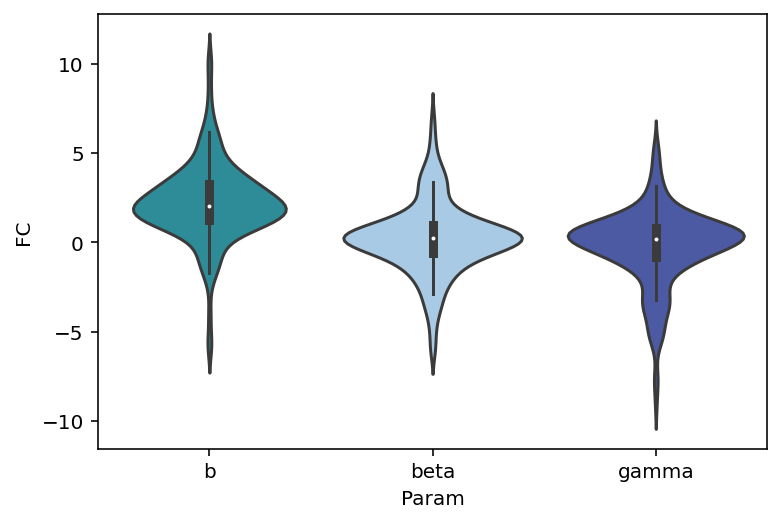

In [35]:
sns.violinplot(data=fc_res, x="Param", y="FC",palette=palette)

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 42.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 41.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 44.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


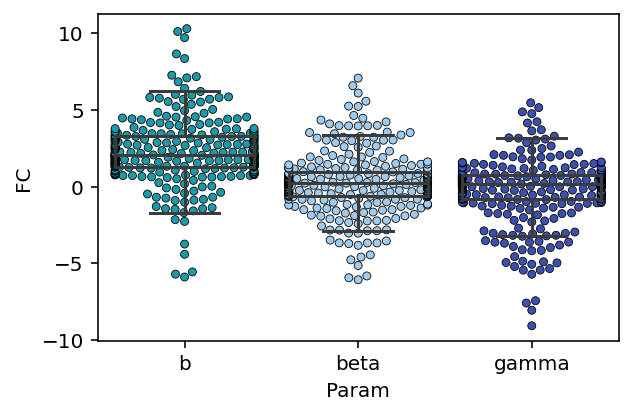

In [39]:
plt.figure(figsize=(4.5,3))
sns.swarmplot(data=fc_res, x="Param", y="FC",palette=palette,size=4,edgecolor='black',linewidth=0.4,zorder=0)
sns.boxplot(data=fc_res, x="Param", y="FC",palette=palette,showfliers=False,boxprops={'facecolor':'None'})

plt.tight_layout()
plt.savefig('burstsize_norman.pdf')

<AxesSubplot:xlabel='Param', ylabel='FC'>

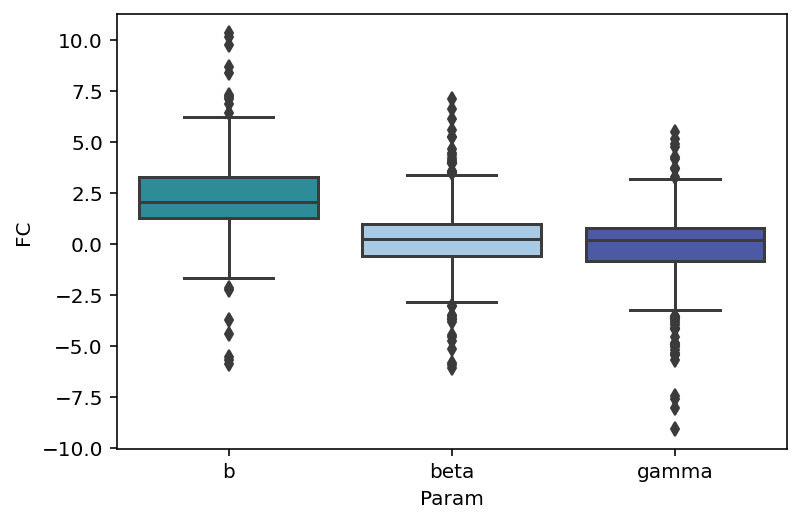

In [92]:
sns.boxplot(data=fc_res, x="Param", y="FC",palette=palette,)

<AxesSubplot:xlabel='sgRNA', ylabel='FC'>

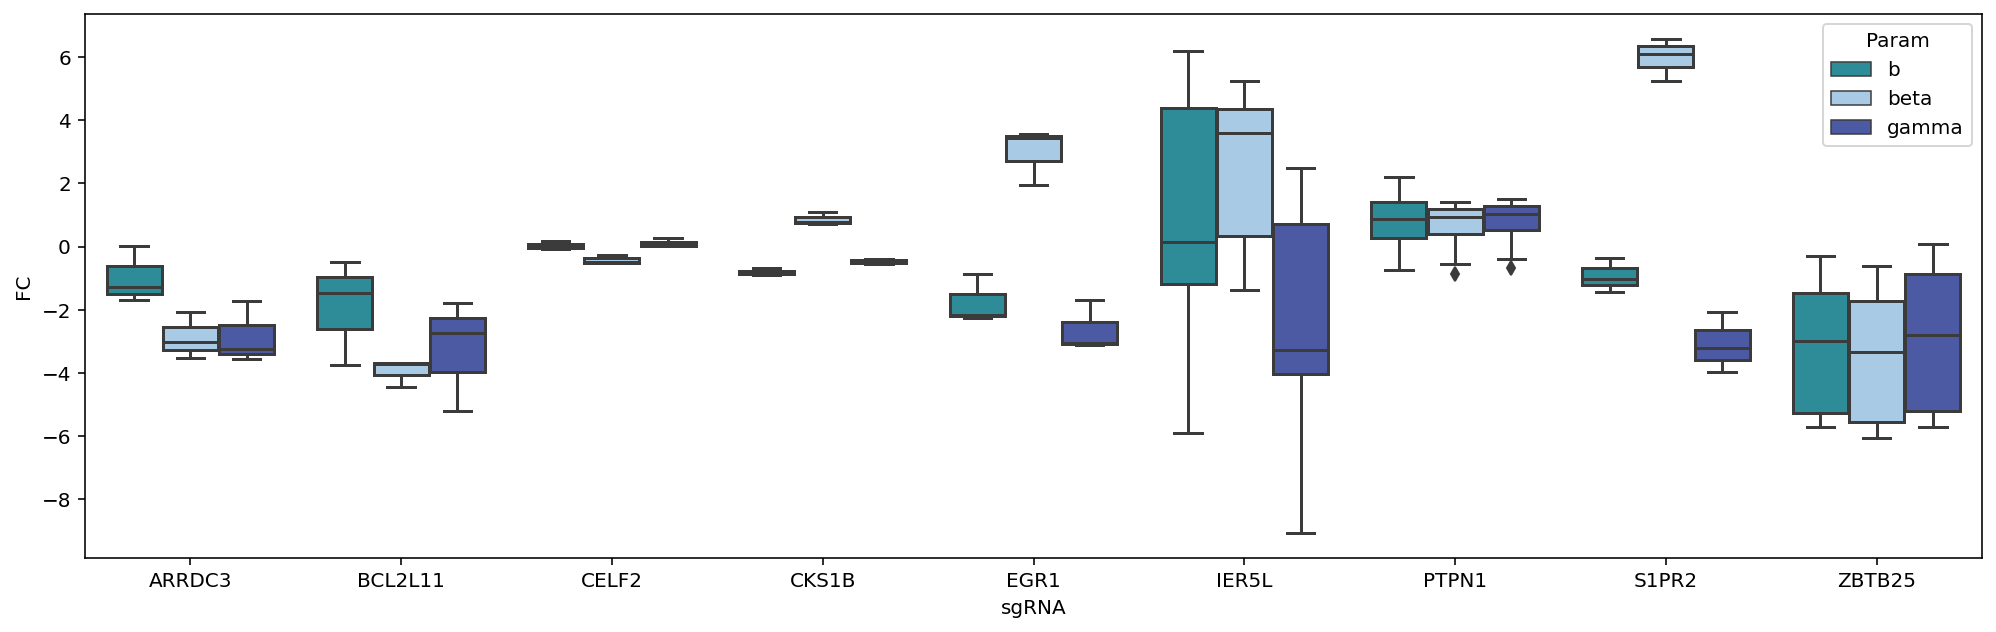

In [42]:
plt.figure(figsize=(17,5))
b_sub = fc_res[fc_res.Param.isin(['b'])]
gs = np.unique(b_sub[b_sub.FC < 0].sgRNA)
sns.boxplot(data=fc_res[fc_res.sgRNA.isin(gs)], x="sgRNA", y="FC",hue='Param',palette=palette)

<AxesSubplot:xlabel='sgRNA', ylabel='FC'>

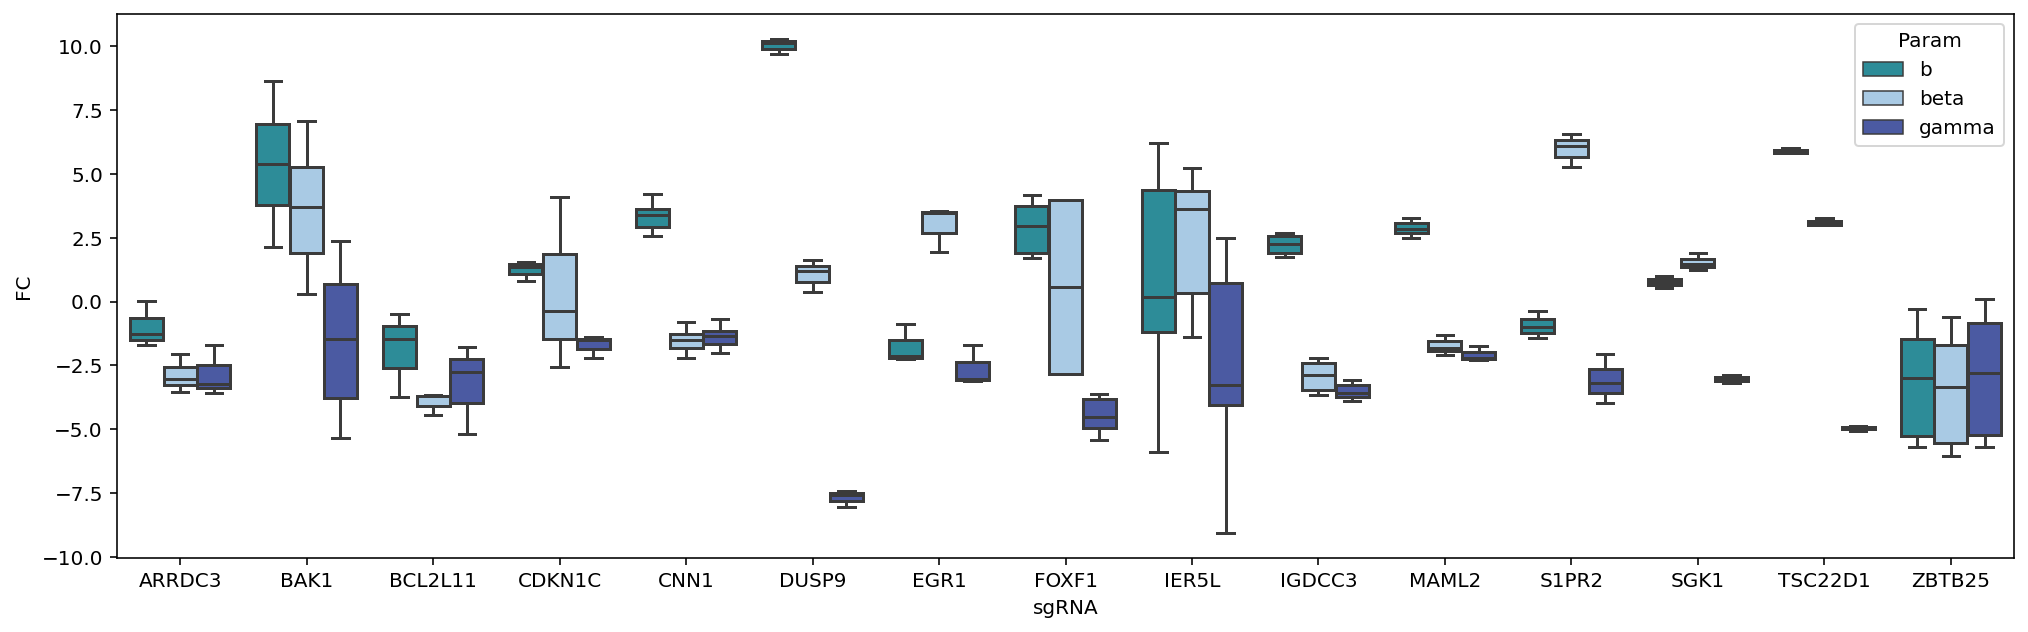

In [67]:
plt.figure(figsize=(17,5))
b_sub = fc_res[fc_res.Param.isin(['gamma'])]
gs = np.unique(b_sub[b_sub.FC < -2].sgRNA)
sns.boxplot(data=fc_res[fc_res.sgRNA.isin(gs)], x="sgRNA", y="FC",hue='Param',palette=palette)

In [52]:
# a e s t h e t i c s
from matplotlib.colors import ListedColormap

#all
col_gold = [203/255,197/255,149/255]
col_gray = [116/255,112/255,113/255]
col_red = [212/255,107/255,75/255]
col_b = ['#1B9AAA']
col_beta = ['#9fcbee']
col_gamma =['#3C50B1']
col_expr = ['#9299A0']

### SI figures
ms = 0.7
lw = ms
ms_fail = 1
alf = 0.3
alf_fail = 0.5
sifig_aesth = (ms,lw,ms_fail,alf,alf_fail)

### Body figures
ms = 2
lw = ms
ms_fail = 2
alf = 0.3
alf_fail = 0.8
msfig_aesth = (ms,lw,ms_fail,alf,alf_fail)

markerstyle = None

c_highlight = col_red
c1 = [173/255,214/255,200/255]
c2 = [59/255,131/255,130/255]
ncol=20
cmap = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(3)]).T)

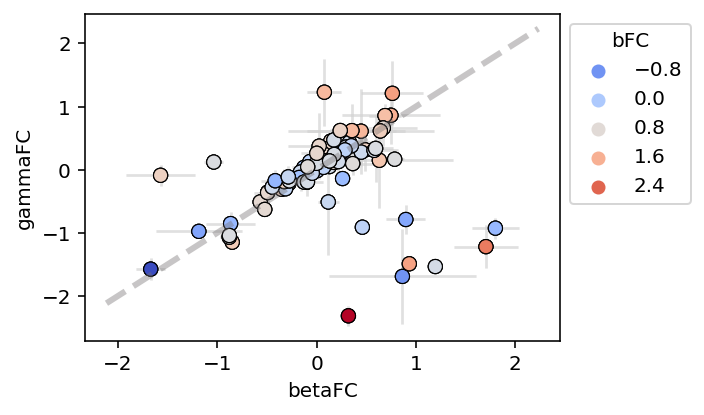

In [166]:
#PUT ERROR BARS HERE (GET THE AVG + VAR FOR EACH GENE )

freq = pd.DataFrame()
freq['betaFC'] = list(fc_res['meanFC'][fc_res['Param'].isin(['beta'])])
freq['gammaFC'] = list(fc_res['meanFC'][fc_res['Param'].isin(['gamma'])])
freq['bFC'] = list(fc_res['meanFC'][fc_res['Param'].isin(['b'])]) #list(np.log1p(fc_res['meanS'][fc_res['Param'].isin(['gamma'])]))

freq['betaStd'] = list(np.sqrt(fc_res['vars'][fc_res['Param'].isin(['beta'])]))
freq['gammaStd'] = list(np.sqrt(fc_res['vars'][fc_res['Param'].isin(['gamma'])]))

fig, ax1 = plt.subplots(1, 1,figsize=(5,3))
g=sns.scatterplot(data=freq,x='betaFC', y='gammaFC',hue='bFC',edgecolor='black',ax=ax1,
                 palette='coolwarm',s=50)

ax1.errorbar(freq['betaFC'],freq['gammaFC'],freq['betaStd'],freq['gammaStd'],
                     marker=markerstyle,ms=ms,c='lightgrey',alpha=alf,
                linestyle='None',linewidth=lw/1.5,zorder=-100)


#plt.plot(freq['betaFC'],[1]*len(freq['betaFC']),'--',color=col_red,linewidth=3,alpha=0.4) 
rho = np.corrcoef(freq.betaFC,freq.gammaFC)[0][1]
p = scipy.stats.spearmanr(freq.betaFC,freq.gammaFC)[0]

# ax1.text(.05,.8,r'$r$ = {:.2f}'.format(rho),fontsize=14,transform=ax1.transAxes)
# ax1.text(.05,.9,r'$\rho$ = {:.2f}'.format(p),fontsize=14,transform=ax1.transAxes)
   
xl = ax1.get_xlim()
ax1.plot(xl,xl,'--',color=col_gray,linewidth=3,alpha=0.4)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig('burstfreq_norman.pdf')

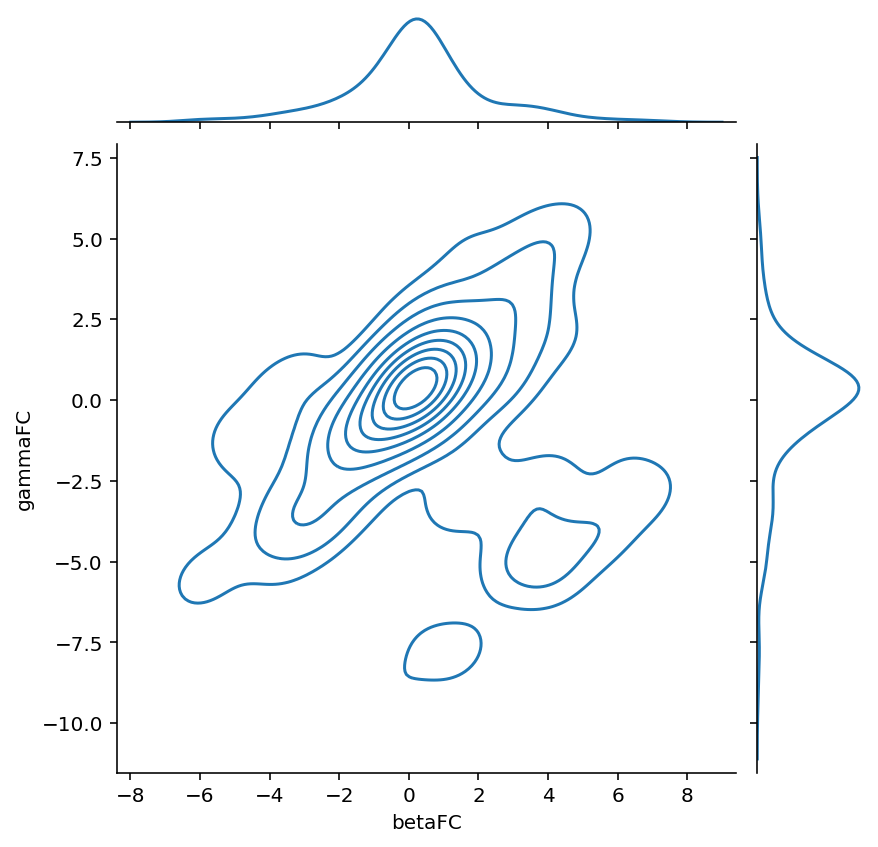

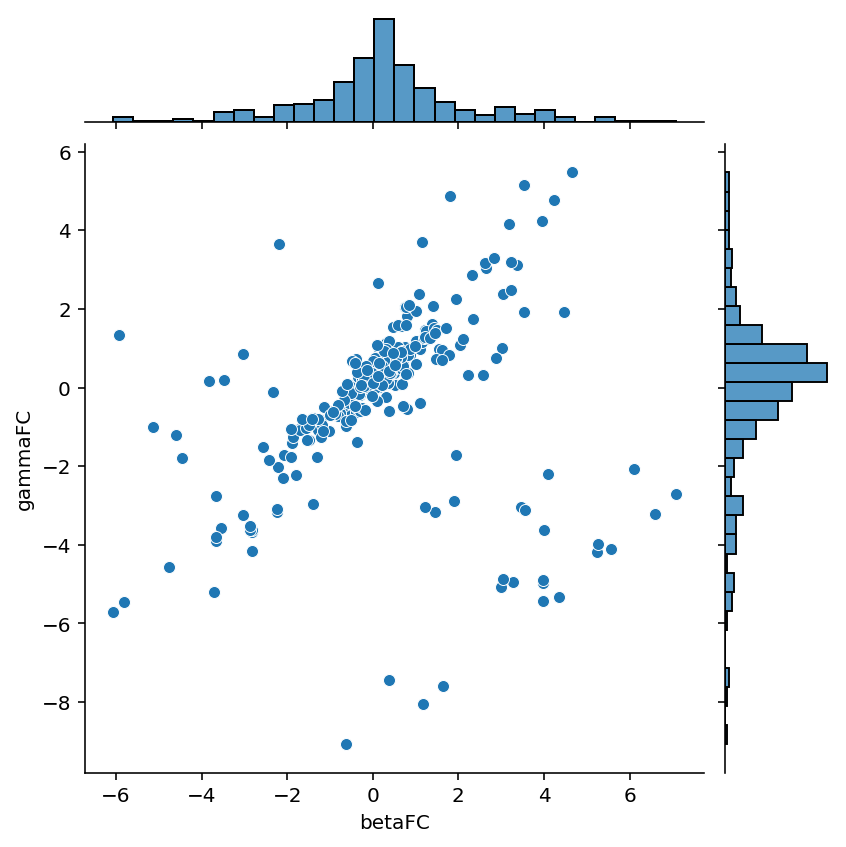

In [65]:
sns.jointplot(data=freq, x="betaFC", y="gammaFC",kind='kde')
#sns.jointplot(data=freq, x="betaFC", y="gammaFC")

**Which conditions and genes are 'informative'** 

Use Fisher Info (from Hessian of KLD)

In [30]:
len(sr_arr)

277

In [ ]:
#Fisher information...
b_info = []
beta_info = []
gamma_info = []

n_cells = []
avg_depth = []

for s in range(len(sr_arr)):
    hess = [sr_arr[s].par_fun_hess(x)
            for x in zip(range(sr_arr[s].n_genes), [sd_arr[s]] * sr_arr[s].n_genes)
            ]
    b_sum = 0
    beta_sum = 0
    gamma_sum = 0
    for h in range(len(hess)):
        b_sum += hess[h][0,0]
        beta_sum += hess[h][1,1]
        gamma_sum += hess[h][2,2]  #Sum information per parameter over genes
    
    b_info += [b_sum]
    beta_info += [beta_sum]
    gamma_info += [gamma_sum]
        
    n_cells += [sd_arr[s].n_cells]
    avg_depth += [np.mean(np.sum(sd_arr[s].layers[1],axis=0))]  #Avg read depth

In [45]:
fish_df = pd.DataFrame()
fish_df['b Info'] = b_info
fish_df['beta Info'] = beta_info
fish_df['gamma Info'] = gamma_info
fish_df['No. Cells'] = n_cells
fish_df['Avg. Depth'] = avg_depth
fish_df.head()

,b Info,beta Info,gamma Info,No. Cells,Avg. Depth
0,20659.395015,9504.147494,13674.970249,3255,5048.192627
1,21023.708712,9486.309782,14183.223308,2679,5128.104890
2,21063.191444,9505.302978,14076.055982,2622,5108.545767
3,20996.542102,9458.375207,14040.984532,2362,5076.903895
4,20512.476222,9304.672758,13594.734653,1018,4602.054028


In [62]:
if_single = ['Neg' in i for i in dataset_names]
fish_df['Single Cond'] = if_single

In [66]:
palette

{'b': '#1B9AAA', 'beta': '#9fcbee', 'gamma': '#3C50B1', 'expr': '#9299A0'}

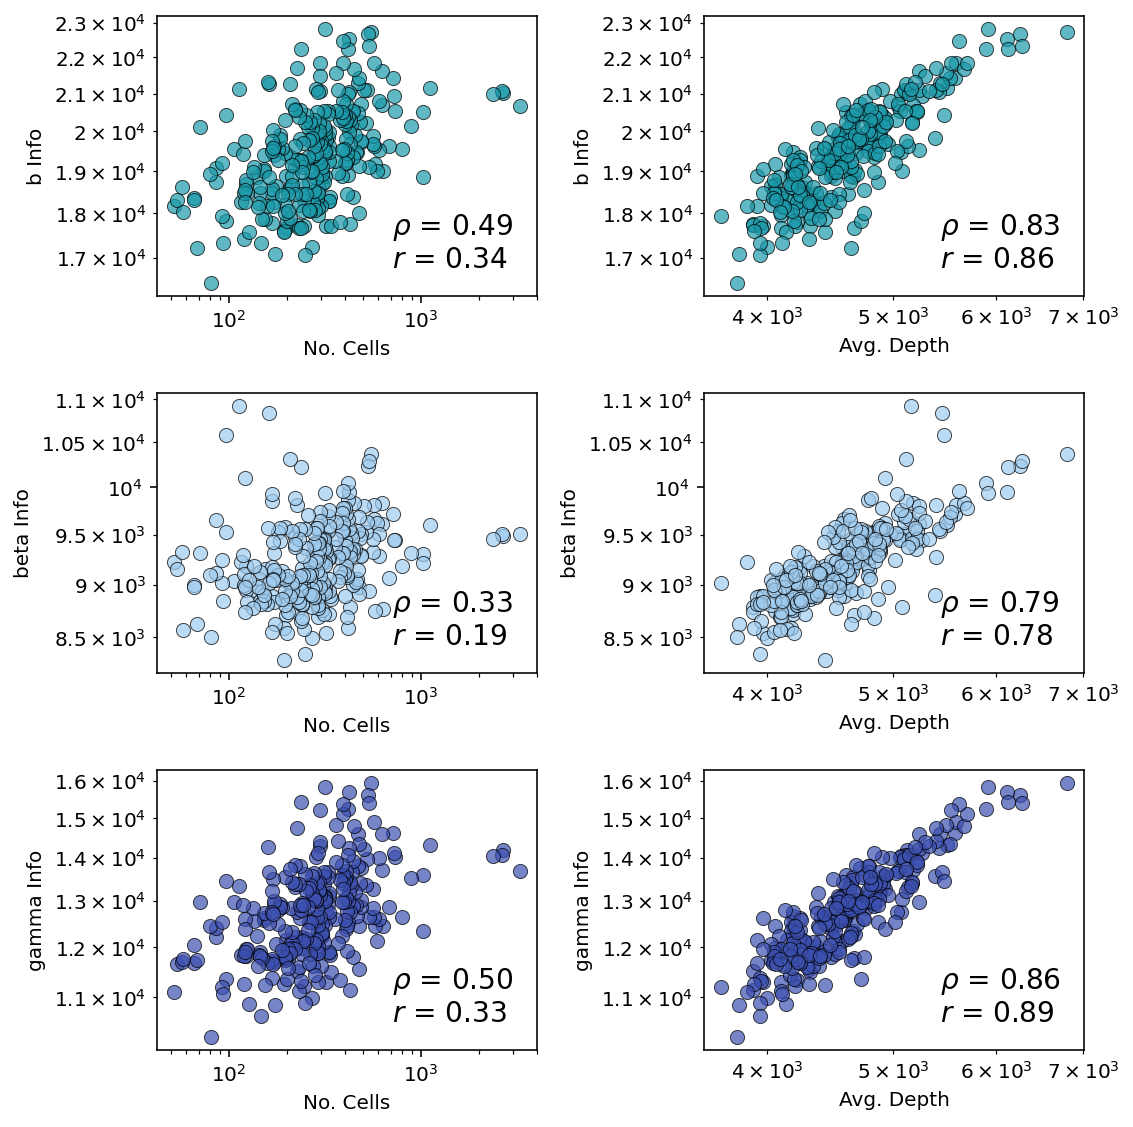

In [107]:
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(8,8))
rows = ['b Info','beta Info','gamma Info']
r_palette = {'b Info': '#1B9AAA', 'beta Info': '#9fcbee', 'gamma Info': '#3C50B1'}
for rs in range(len(rows)):
    row = rows[rs]
    cl = r_palette[row]
    
    g1=sns.scatterplot(data=fish_df, x='No. Cells',y=row,color=cl,
                   edgecolor='black',linewidth=0.5,s=50,ax=ax[rs,0],alpha=0.7)
    
    g2=sns.scatterplot(data=fish_df, x='Avg. Depth',y=row,color=cl,
                   edgecolor='black',linewidth=0.5,s=50,ax=ax[rs,1],alpha=0.7)
    
    rho = np.corrcoef(fish_df['No. Cells'],fish_df[row])[0][1]
    p = scipy.stats.spearmanr(fish_df['No. Cells'],fish_df[row])[0]
    
    ax[rs,0].text(.62,.1,r'$r$ = {:.2f}'.format(rho),fontsize=14,transform=ax[rs,0].transAxes)
    ax[rs,0].text(.62,.22,r'$\rho$ = {:.2f}'.format(p),fontsize=14,transform=ax[rs,0].transAxes)
    
    ax[rs,0].set_yscale('log')
    ax[rs,0].set_xscale('log')
    
    rho = np.corrcoef(fish_df['Avg. Depth'],fish_df[row])[0][1]
    p = scipy.stats.spearmanr(fish_df['Avg. Depth'],fish_df[row])[0]
    
    ax[rs,1].text(.62,.1,r'$r$ = {:.2f}'.format(rho),fontsize=14,transform=ax[rs,1].transAxes)
    ax[rs,1].text(.62,.22,r'$\rho$ = {:.2f}'.format(p),fontsize=14,transform=ax[rs,1].transAxes)
    
    ax[rs,1].set_yscale('log')
    ax[rs,1].set_xscale('log')

    
    #ax[rs,1].yaxis.set_ticklabels([''])
 
    
plt.tight_layout()
plt.savefig('norman_info_cells_depth.pdf')

In [108]:
# sns.scatterplot(data=fish_df, x='No. Cells',y='beta Info',hue='Single Cond')
# plt.yscale('log')
# plt.xscale('log')

**Analyze Examples of Known Relationships**

MAYBE REMOVE THIS

In [63]:
#'ARRDC3' downregulates 'ITGB4'
#SNAI1 repressed CDH1 (Cadherin),NANOG, NR5A2, KIT -> https://stemcellsjournals.onlinelibrary.wiley.com/doi/full/10.1002/stem.1898
# Apoptosis--> global mRNA decay ,
#CBL targets -->EGFR, FLT3, KIT, MPL https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4775400/
#ubash3b (also + CBL) targets --> 
#ETS/FEV trans factors
#KMT2A methylation 
#MIDN degrades FOSB, EGR1, NR4A1, IRF4, NEUROD1, PAX8, GATA1 https://www.science.org/doi/10.1126/science.adh5021
#RUNX1T1 --> PTK2B, RBFOX2 alt splicing https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7822815/

In [ ]:
#MAPK1 - EGR1 https://www.mdpi.com/2073-4409/9/4/877

#https://www.frontiersin.org/journals/oncology/articles/10.3389/fonc.2021.642547/full
#TGFB1,CDKN1A, PTK2 (FAK),   -->EGR1 targets
#Better is ITGA2B

# --- don't have--

#INHBA, CD9, and ITGA2B   CD41 -->FOSB


#MYB targets  
# LMO2, STAT5A,IKZF1 .....not MYADM,GATA2,

In [182]:
#Unfortunately many genes from the literature (ABOVE) have low expression (Very variable parameters)

In [66]:
#Get genes with FC < 1 in S_means for CBL/CNN1 condition
finds = [d for d in dataset_names if (('CBL' in d) and ('CNN1' in d))]
inds = [dataset_names.index(f) for f in finds]
dset = inds[0]

dset

122

In [118]:
#If desired, get list of genes with param FCs but low spliced FCs
X_both = sd_arr[dset].layers[1,:,:].T
print(X_both.shape)

FC = np.log2(s_means[dset,:]/s_means[control_inds[1],:])

#Look for selected genes with small S FC
fc_filt = (np.abs(FC)<1)
print(np.sum(fc_filt))

#Filt for large param FCs
bFC = sr_arr[dset].param_estimates[0,:,0]-sr_arr[control_inds[1]].param_estimates[0,:,0]
betaFC = sr_arr[dset].param_estimates[0,:,1]-sr_arr[control_inds[1]].param_estimates[0,:,1]
gammaFC = sr_arr[dset].param_estimates[0,:,2]-sr_arr[control_inds[1]].param_estimates[0,:,2]

new_filt = fc_filt & (~sr_arr[dset].rejected_genes) & ((np.abs(np.log2(10**bFC))>1) | (np.abs(np.log2(10**betaFC))>1)  | (np.abs(np.log2(10**gammaFC))>1))


(246, 3084)
2978


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.


In [176]:
cond_names = ['ARRDC3','SNAI1','CBL','MIDN','RUNX1T1','MAPK1','EGR1','ZBTB1',['CBL','CNN1']]
targ_names = [['ITGB4'],['CDH1','NANOG', 'NR5A2', 'KIT'],['EGFR', 'FLT3', 'KIT', 'MPL'],
              ['FOSB', 'EGR1', 'NR4A1', 'IRF4', 'NEUROD1', 'PAX8', 'GATA1'],
             ['PTK2B', 'RBFOX2'],
             ['EGR1'],
             ['TGFB1','CDKN1A', 'PTK2'],
             ['LMO2'],
             ['HBZ', 'SLC25A37', 'SPI1','PCGF6','NEMF' , 'KTN1',  'MTFMT' , 'SNRPA1' ]]


1


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log2
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


2


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log2
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:3963: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a*t, out=out))
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


1


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log2
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


1


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log2
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log2
/h

2
2
1
3
1


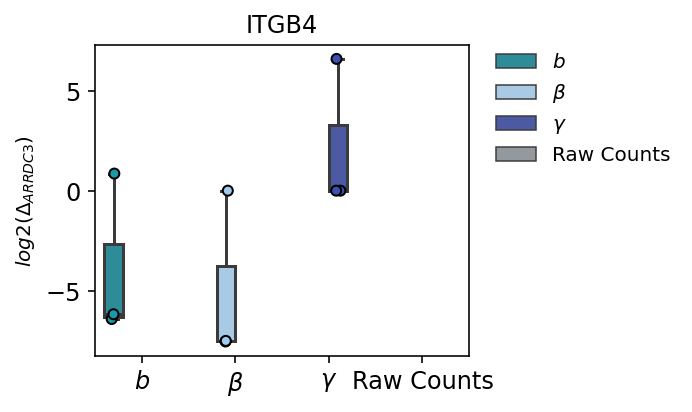

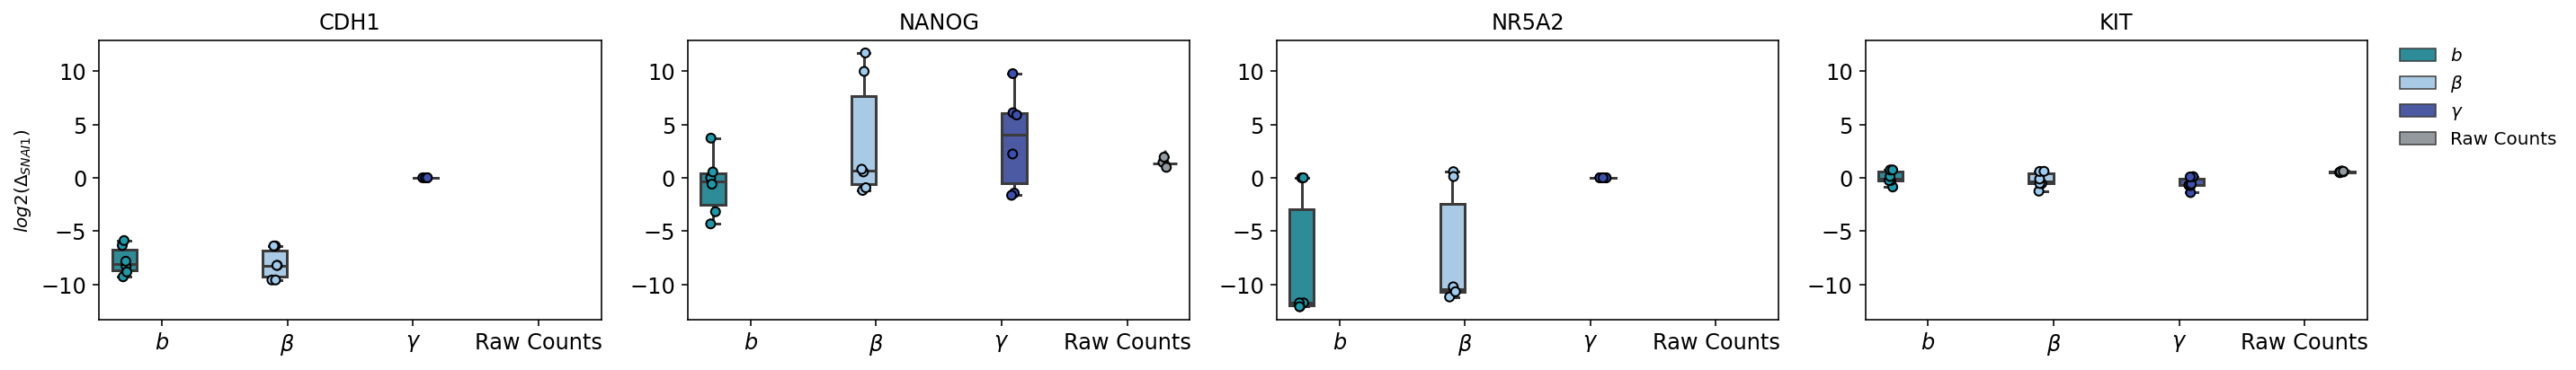

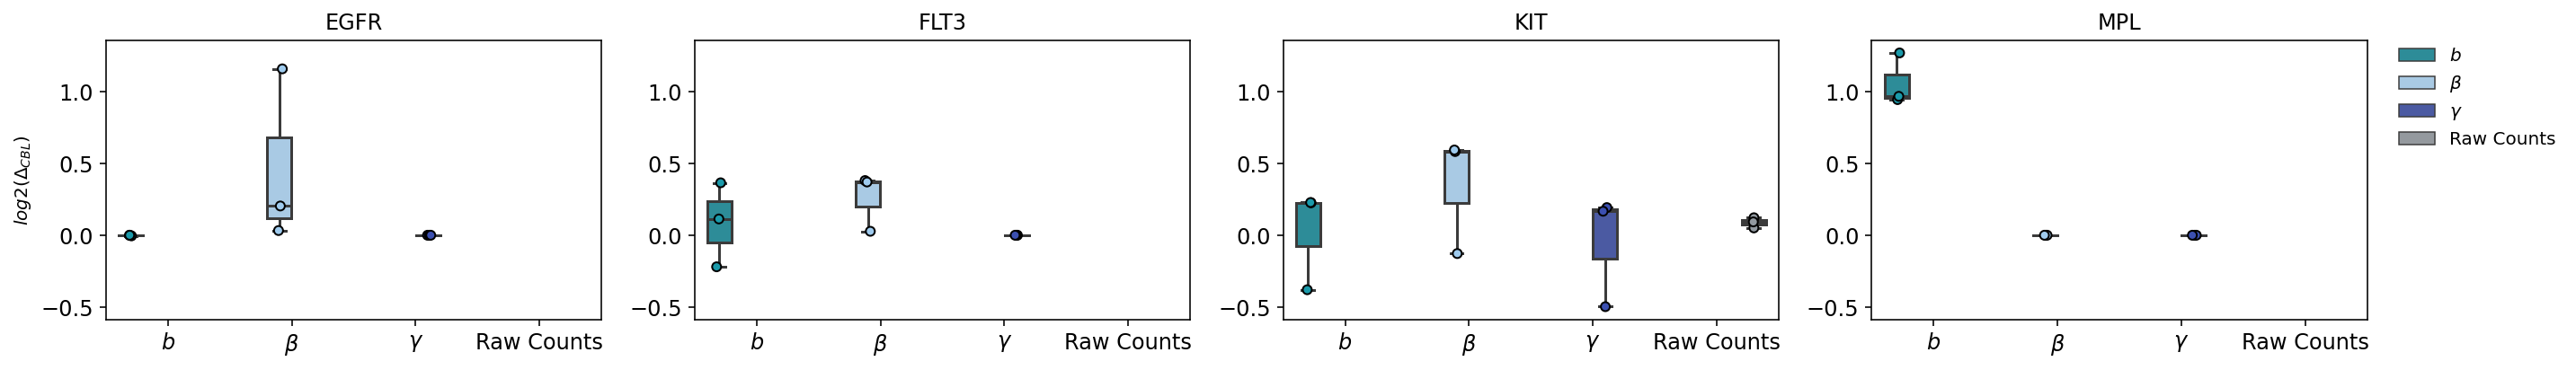

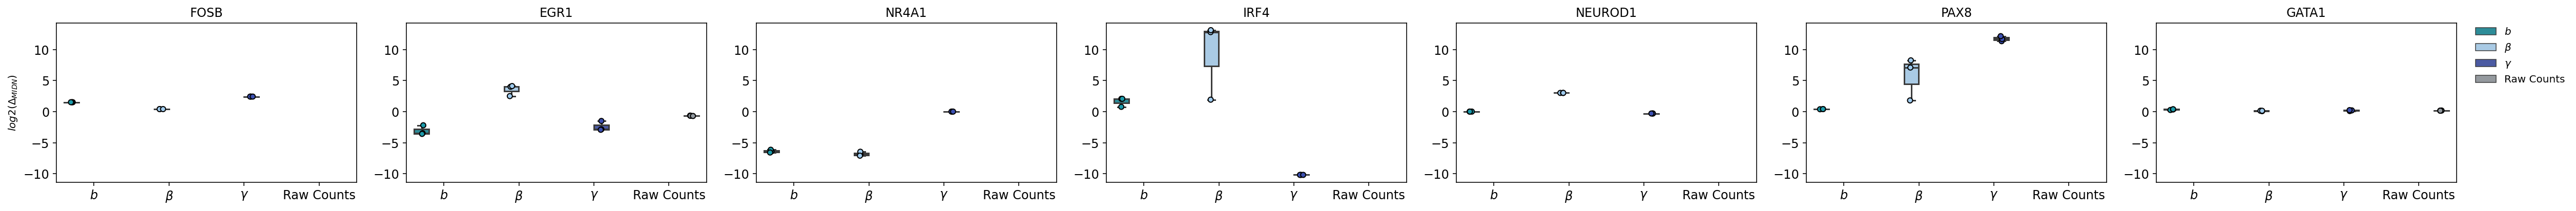

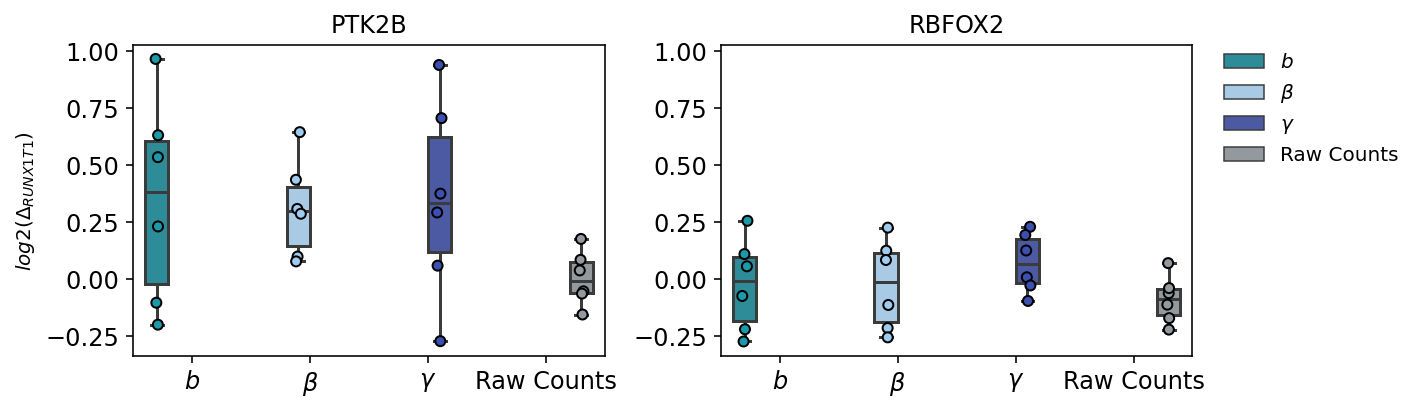

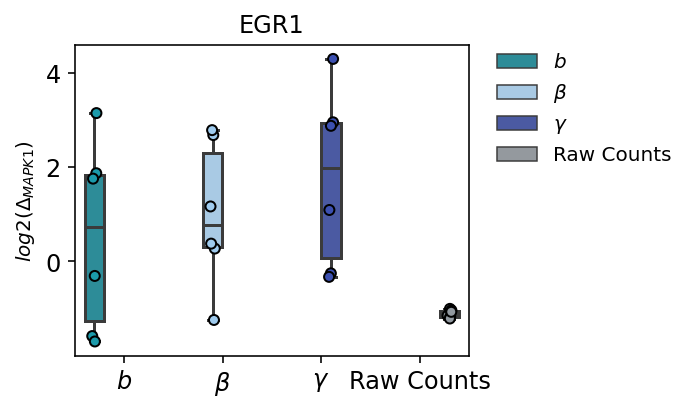

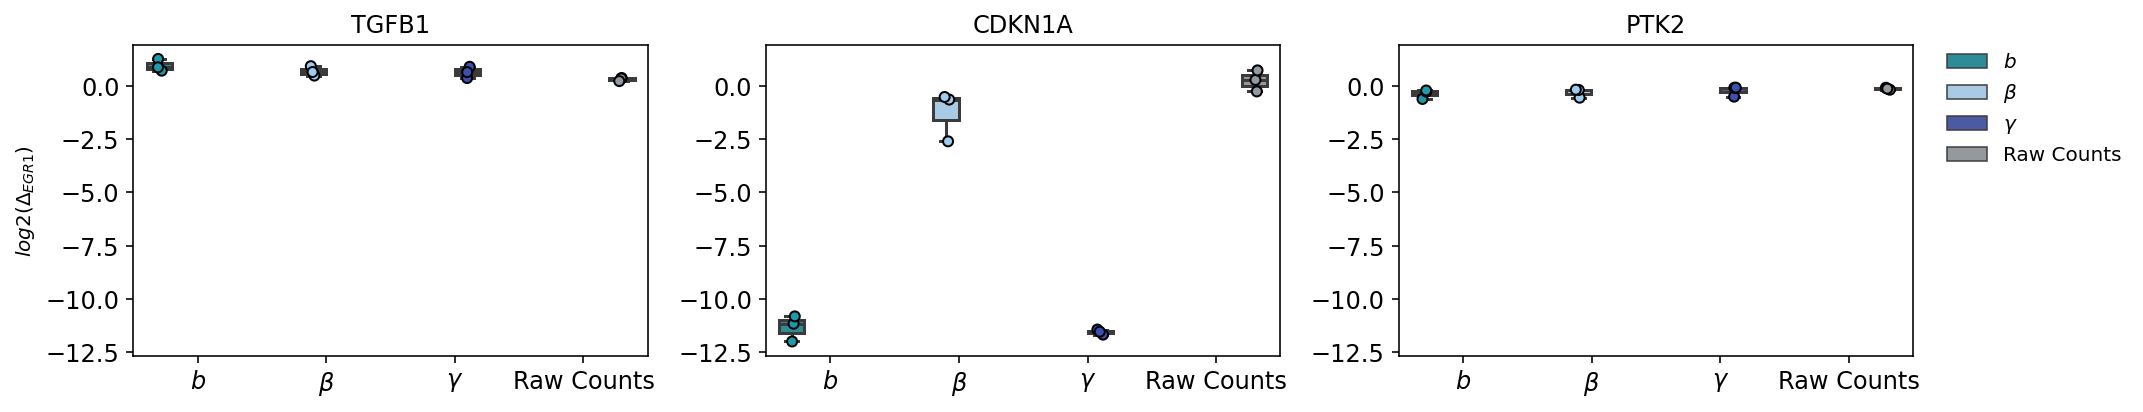

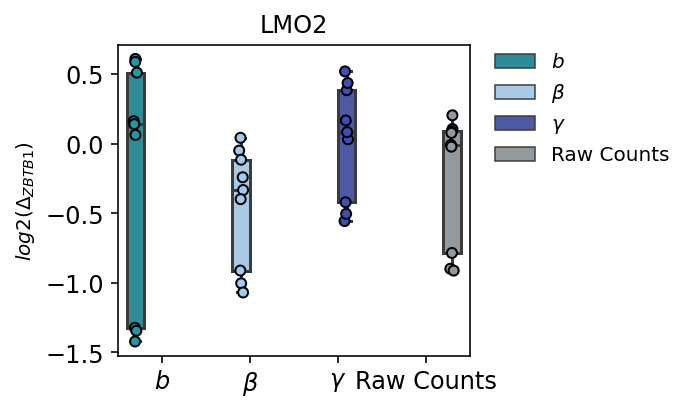

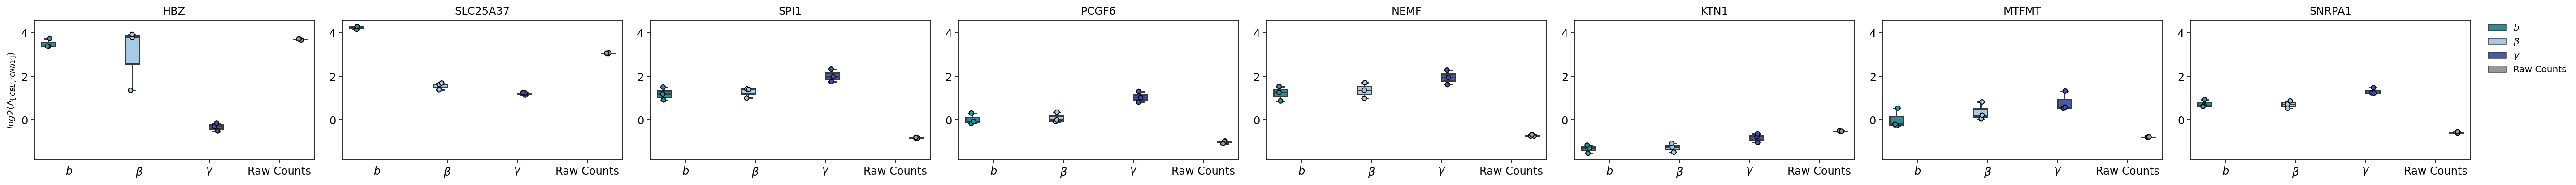

In [181]:
ctrls = par_vals_uncorrected[control_filt,:,:]
gene_names = sr_arr[0].gene_names

ticksize=12

for cds in range(len(cond_names)):
    c = cond_names[cds]
    
    if len(c) == 2:
        finds = [d for d in dataset_names if ((c[0] in d) and (c[1] in d))]
    else:
        finds = [d for d in dataset_names if ((c in d) and ('Neg' in d))]
    inds = [dataset_names.index(f) for f in finds]
    print(len(inds))
    
    g_toplot = targ_names[cds]
            
    
    fig1, ax1 = plt.subplots(nrows=1,ncols=len(g_toplot),figsize=(5*len(g_toplot),3),sharey=True)
                

    for j in range(len(g_toplot)):
            g_filt = gene_names == g_toplot[j]
            fcs = []
            param_nm = []
            cond_nm = []
            
            for i in range(len(inds)):
                dset = inds[i]
                perturb = par_vals_uncorrected[dset,g_filt,:]

                sub_c = ctrls[:,g_filt,:]
                
                calcs = [perturb[0,0] - sub_c[0,0,0],perturb[0,0] - sub_c[1,0,0],perturb[0,0] - sub_c[2,0,0],
                    perturb[0,1] - sub_c[0,0,1],perturb[0,1] - sub_c[1,0,1],perturb[0,1] - sub_c[2,0,1],
                   perturb[0,2] - sub_c[0,0,2],perturb[0,2] - sub_c[1,0,2],perturb[0,2] - sub_c[2,0,2]]
                
                #print(g_toplot[j]+": "+str(s_means[dset,g_filt]))
                
                
                s_fcs = list(np.log2(s_means[dset,g_filt]/s_means[control_filt,g_filt]))

                fcs +=  list(np.log2(10**(np.array(calcs))))
                fcs += s_fcs
                
                param_nm += ['b']*3+['beta']*3+['gamma']*3+['expr']*3
                cond_nm += [c]*12
    
            dfsub = pd.DataFrame()
            dfsub['FC'] = fcs
            dfsub['Param'] = param_nm
            dfsub['Cond'] = cond_nm


            if len(g_toplot)==1:
                to_ax = ax1
            else:
                to_ax = ax1[j]
                
            sns.boxplot(x="Param", y="FC", hue="Param", palette=palette,
                        data=dfsub,ax=to_ax,dodge=True)

            sns.stripplot(x="Param", y="FC", hue="Param", data=dfsub, palette=palette,
                          dodge=True, ax=to_ax, ec='k', linewidth=1)

            if j == len(g_toplot)-1:
                handles, labels = to_ax.get_legend_handles_labels()

                # When creating the legend, only use the first two elements
                # to effectively remove the last two.
                l = to_ax.legend(handles[0:4], [r'$b$', r'$\beta$', r'$\gamma$', 'Raw Counts'], frameon=False,
                                    bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            else:
                to_ax.legend_.remove()

            to_ax.set_xticklabels([r'$b$', r'$\beta$', r'$\gamma$', 'Raw Counts'],fontsize=ticksize)
            to_ax.tick_params(axis='y', labelsize=ticksize)
            
            to_ax.yaxis.set_tick_params(labelleft=True)

            to_ax.set_ylabel(None)
            to_ax.set_xlabel(None)
            
            to_ax.set_title(g_toplot[j])
            
            if j == 0:
                to_ax.set_ylabel(r'$log2(\Delta_{'+str(c)+'})$')
            
    plt.tight_layout()
    plt.savefig('paramsvstandard_norman.pdf')